In [1]:
# load R packages
require(data.table)
library(DESeq2)
library(ggplot2)
library(scales)
library(gridExtra)
library(gplots)
library(RColorBrewer)

# load R functions
source('./scripts/get_dumbbell_heat_plot.R')
source('./scripts/get_local_stability_plot.R')

# load datasets
stemscan_7_mer<-read.table("./MapToCleave_supplemental_data/DataS7:local_free_energy_7-mer_of_MapToCleave_processed_and_unprocessed_miRNA_precursors.txt",sep="\t",check.names = F)
stemscan_7_mer<-data.frame(t(stemscan_7_mer),check.names = F)

Loading required package: data.table

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attac

### Code related to Figure 1

Identify processed and unprocessed MapToCleave miRNA precursors in HEK-293T cells

In [2]:
# load raw count table of MapToCleave sequences tested in HEK-293T cells
hairpin_countTable<-fread("./MapToCleave_supplemental_data/DataS2:count_table_of_MapToCleave_hairpins_in_HEK_and_NIH3T3.txt",sep="\t",header=TRUE)
hairpin_countTable<-data.frame(hairpin_countTable)
rownames(hairpin_countTable)<-hairpin_countTable[,1]
hairpin_countTable[,1]<-NULL

# Bona fide miRNAs are defined using MirGeneDB annotation 
mirbase_name<-as.data.frame(matrix(unlist(strsplit(rownames(hairpin_countTable),":")),ncol = 4,byrow = T))
mirbase2mirgenedb<-read.table("./data/MirGeneDB_miRBase_id_conversion_2019-10-23.txt")

mirbase_name<-data.frame(lapply(mirbase_name, as.character), stringsAsFactors=FALSE)
mirbase2mirgenedb<-data.frame(lapply(mirbase2mirgenedb, as.character), stringsAsFactors=FALSE)

mirbase_name$mirgenedb<-""
for (i in 1:length(mirbase_name[,1])){
    if(length(mirbase2mirgenedb[mirbase2mirgenedb[,2] == mirbase_name[i,2],][,1]) > 0){
        mirbase_name[i,5]<-mirbase2mirgenedb[mirbase2mirgenedb[,2] == mirbase_name[i,2],][1,1]
    } else {
        mirbase_name[i,5]<-"NA"
    }
}

mirbase_name<-mirbase_name[,c(5,1,2,3,4)]
colnames(mirbase_name)<-c("mirgenedb","mirbase_name","mirbase_ID","sh-lib","mirtron")
mirbase_name$MapToCleave_id<-apply(mirbase_name[,2:5],1,paste,collapse=":")

In [3]:
head(mirbase_name)

,mirgenedb,mirbase_name,mirbase_ID,sh-lib,mirtron,MapToCleave_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,NA,aqu-mir-2014,MI0010222,in,none,aqu-mir-2014:MI0010222:in:none
2,NA,aqu-mir-2015,MI0010223,in,none,aqu-mir-2015:MI0010223:in:none
3,NA,aqu-mir-2018,MI0010226,in,none,aqu-mir-2018:MI0010226:in:none
4,NA,aqu-mir-2019,MI0010227,in,none,aqu-mir-2019:MI0010227:in:none
5,NA,aqu-mir-2021,MI0010282,in,none,aqu-mir-2021:MI0010282:in:none
6,NA,ath-MIR156a,MI0000178,in,none,ath-MIR156a:MI0000178:in:none


In [4]:
# small RNA RPM normalization based on human or mouse miRNAs counts.
hairpin_miRNA_RPM<-hairpin_countTable[,grep(".sRNA",colnames(hairpin_countTable))]
for (i in 1:length(hairpin_miRNA_RPM)){
    if (length(grep("HEK",colnames(hairpin_miRNA_RPM)[i]))!=0){
        hairpin_miRNA_RPM[,i]<-hairpin_miRNA_RPM[,i]/sum(hairpin_miRNA_RPM[grep("hsa",rownames(hairpin_miRNA_RPM)),i])*10^6
    } else {
        hairpin_miRNA_RPM[,i]<-hairpin_miRNA_RPM[,i]/sum(hairpin_miRNA_RPM[grep("mmu",rownames(hairpin_miRNA_RPM)),i])*10^6
    }
    
}

# DNA RPM normalization based on all counts. 
hairpin_DNA_RPM<-hairpin_countTable[,grep(".DNA",colnames(hairpin_countTable))]
for (i in 1:length(hairpin_DNA_RPM)){
    hairpin_DNA_RPM[,i]<-hairpin_DNA_RPM[,i]/sum(hairpin_DNA_RPM[,i])*10^6
}

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



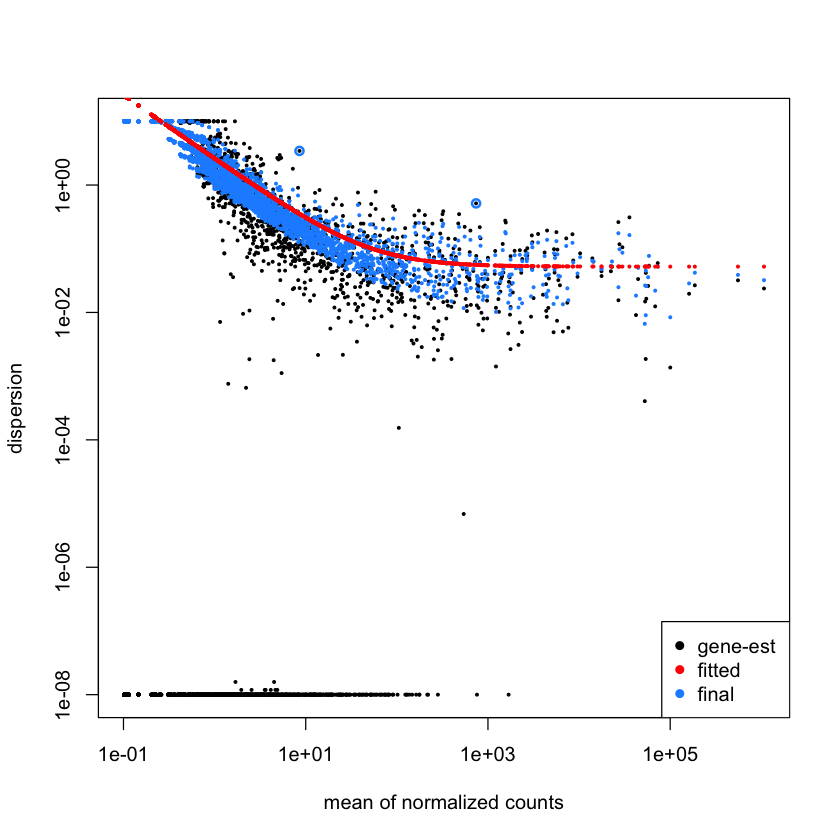

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



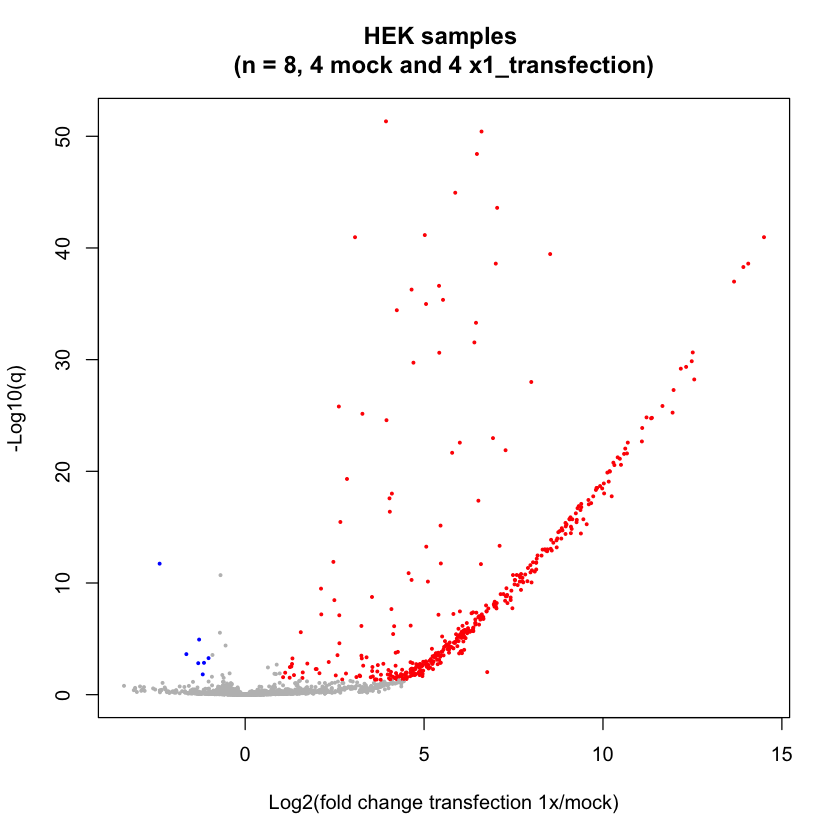

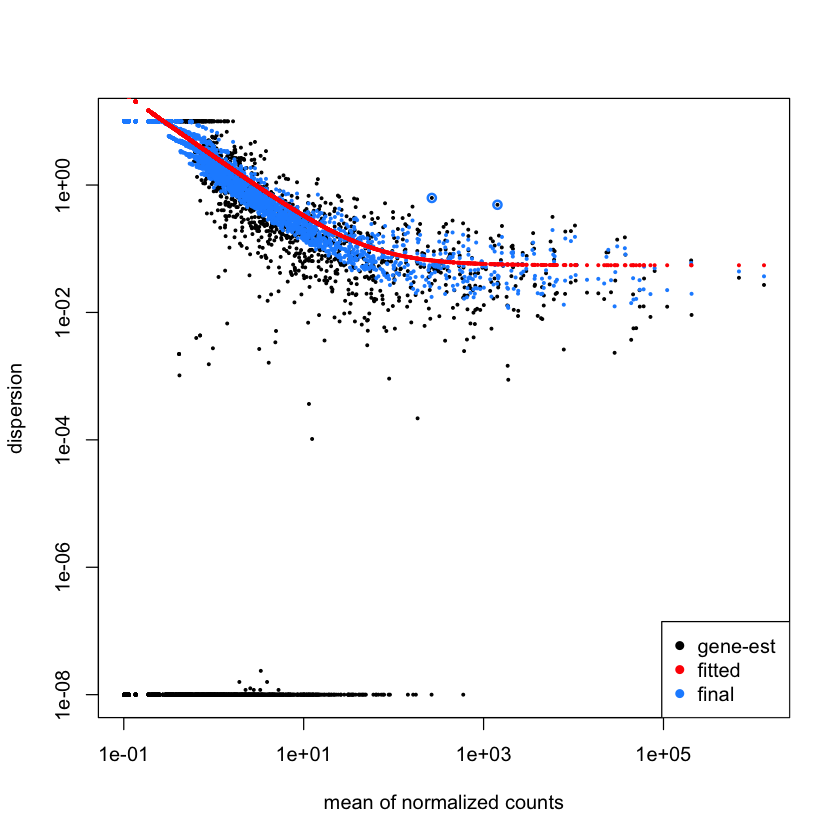

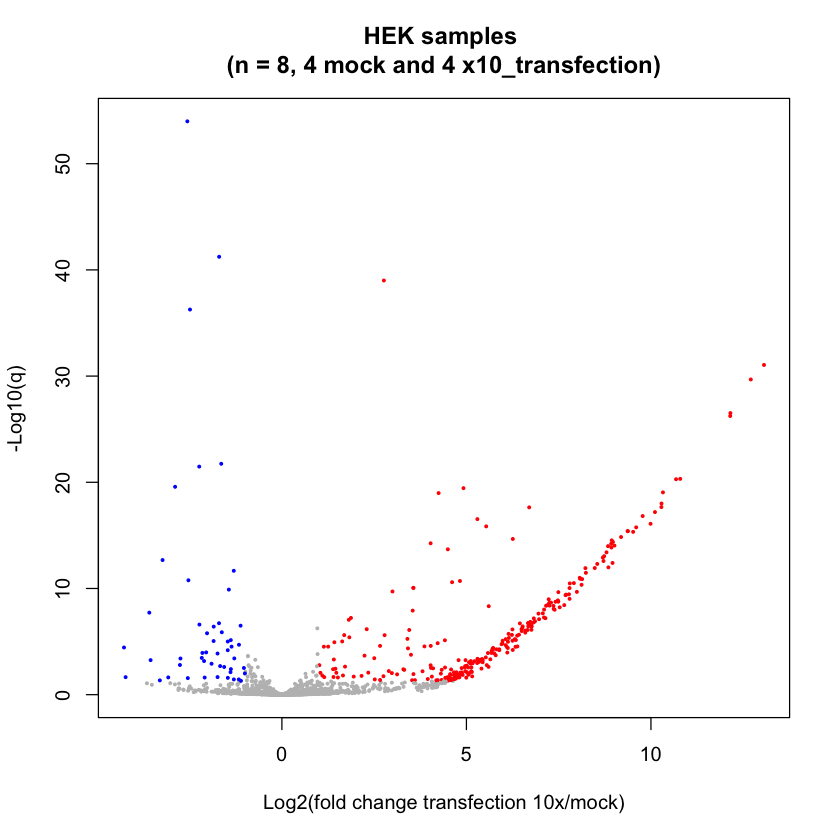

In [5]:
options(repr.plot.width=7, repr.plot.height=7)

# Statistics of transfected plasmid DNA, processed and unprocessed MapTocleave miRNA precursors. 
## the types and number of DNA oligos that are sucessfully transfected into cells (HEK cells). (RPM >= 5)
sh.lib_DNA_oligos_transfected.HEK<-rownames(hairpin_DNA_RPM[hairpin_DNA_RPM$HEK_R4_sh.lib_1x_1000ng_NOR.DNA >= 5,])
sh.lib_DNA_oligos_transfected.HEK_n<-table(gsub(":.*","",gsub("_.*","",gsub("-.*","",sh.lib_DNA_oligos_transfected.HEK))))
sh.lib_DNA_oligos_transfected.HEK_n<-data.frame(sh.lib_DNA_oligos_transfected.HEK_n)
colnames(sh.lib_DNA_oligos_transfected.HEK_n)<-c("type","DNA_oligos_transfected_in_HEK")
df_summary<-sh.lib_DNA_oligos_transfected.HEK_n

sh.lib_DNA_oligos_transfected.HEK_mirgenedb<-sh.lib_DNA_oligos_transfected.HEK
sh.lib_DNA_oligos_transfected.HEK_mirgenedb<-sh.lib_DNA_oligos_transfected.HEK_mirgenedb[sh.lib_DNA_oligos_transfected.HEK_mirgenedb %in% mirbase_name[mirbase_name[,1]!="NA",][,6]]
sh.lib_DNA_oligos_transfected.HEK_n<-table(gsub(":.*","",gsub("_.*","",gsub("-.*","",sh.lib_DNA_oligos_transfected.HEK_mirgenedb))))
sh.lib_DNA_oligos_transfected.HEK_n<-data.frame(sh.lib_DNA_oligos_transfected.HEK_n)
colnames(sh.lib_DNA_oligos_transfected.HEK_n)<-c("type","DNA_oligos_transfected_in_HEK")
df_summary_mirgenedb<-sh.lib_DNA_oligos_transfected.HEK_n

## the types and number of transfected DNA oligos are transcribed and processed (HEK 1x vs 0x). (DESeq2 analysis based on fold change between mock and transfection)
hairpin_miRNA_HEK_mock.1x<-hairpin_countTable[,grep(".sRNA",colnames(hairpin_countTable))]
hairpin_miRNA_HEK_mock.1x<-hairpin_miRNA_HEK_mock.1x[grep("HEK",colnames(hairpin_miRNA_HEK_mock.1x))]
hairpin_miRNA_HEK_mock.1x<-hairpin_miRNA_HEK_mock.1x[,grep("_0x_|_1x_",colnames(hairpin_miRNA_HEK_mock.1x))]

## Identify processed hairpins (HEK 1x vs 0x) using DESeq2
se <- hairpin_miRNA_HEK_mock.1x[rowSums(hairpin_miRNA_HEK_mock.1x)>0,]
seDesign = data.frame(row.names=colnames(se),samples=colnames(se),condition=as.factor(c(rep(c("mock"),times=4),rep(c("transfection"),times=4))))

dds_se <- DESeqDataSetFromMatrix(countData=se,colData=seDesign,design=~condition)
dds <- DESeq(dds_se)
plotDispEsts(dds)
resData = results(dds, contrast=c("condition","transfection","mock"))
Data<-na.omit(resData)
threshold_OE <- Data$pvalue < 0.01 & Data$padj < 0.05 & abs(Data$log2FoldChange) > 1
Data$threshold <- threshold_OE 

Data$color<- "grey"
Data[Data$pvalue < 0.01 & Data$padj < 0.05 & Data$log2FoldChange > 1,]$color<-"red"
Data[Data$pvalue < 0.01 & Data$padj < 0.05 & Data$log2FoldChange < -1,]$color<-"blue"
plot(Data$log2FoldChange,-log10(Data$padj),pch=19,cex=0.3,col=Data$color,
     xlab="Log2(fold change transfection 1x/mock)",ylab="-Log10(q)",
     main="HEK samples \n(n = 8, 4 mock and 4 x1_transfection)")


DE_oligos_hairpin_miRNA_HEK_mock.1x<-rownames(Data[Data$color == "red",])
DE_oligos_hairpin_miRNA_HEK_mock.1x<-DE_oligos_hairpin_miRNA_HEK_mock.1x[DE_oligos_hairpin_miRNA_HEK_mock.1x %in% sh.lib_DNA_oligos_transfected.HEK]
DE_oligos_hairpin_miRNA_HEK_mock.1x_n<-table(gsub(":.*","",gsub("_.*","",gsub("-.*","",DE_oligos_hairpin_miRNA_HEK_mock.1x))))
DE_oligos_hairpin_miRNA_HEK_mock.1x_n<-data.frame(DE_oligos_hairpin_miRNA_HEK_mock.1x_n)
colnames(DE_oligos_hairpin_miRNA_HEK_mock.1x_n)<-c("type","DE_oligos_in_HEK_1x.0x")
df_summary<-merge(df_summary,DE_oligos_hairpin_miRNA_HEK_mock.1x_n,x.by="type",y.by="type",all=TRUE)


DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.1x
DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb[DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb %in% sh.lib_DNA_oligos_transfected.HEK_mirgenedb]
DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb[DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb %in% mirbase_name[mirbase_name[,1]!="NA",][,6]]
DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb_n<-table(gsub(":.*","",gsub("_.*","",gsub("-.*","",DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb))))
DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb_n<-data.frame(DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb_n)
colnames(DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb_n)<-c("type","DE_oligos_in_HEK_1x.0x")
df_summary_mirgenedb<-merge(df_summary_mirgenedb,DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb_n,x.by="type",y.by="type",all=TRUE)

## the types and number of transfected DNA oligos are transcribed and processed (HEK 10x vs 0x). (DESeq2 analysis based on fold change between mock and transfection)
hairpin_miRNA_HEK_mock.10x<-hairpin_countTable[,grep(".sRNA",colnames(hairpin_countTable))]
hairpin_miRNA_HEK_mock.10x<-hairpin_miRNA_HEK_mock.10x[grep("HEK",colnames(hairpin_miRNA_HEK_mock.10x))]
hairpin_miRNA_HEK_mock.10x<-hairpin_miRNA_HEK_mock.10x[,grep("_0x_|_10x_",colnames(hairpin_miRNA_HEK_mock.10x))]

## Identify processed hairpins (HEK 10x vs 0x) using DESeq2
se <- hairpin_miRNA_HEK_mock.10x[rowSums(hairpin_miRNA_HEK_mock.10x)>0,]
seDesign = data.frame(row.names=colnames(se),samples=colnames(se),condition=as.factor(c(rep(c("mock"),times=4),rep(c("transfection"),times=4))))
dds_se <- DESeqDataSetFromMatrix(countData=se,colData=seDesign,design=~condition)
dds <- DESeq(dds_se)
plotDispEsts(dds)
resData = results(dds, contrast=c("condition","transfection","mock"))
Data<-na.omit(resData)
threshold_OE <- Data$pvalue < 0.01 & Data$padj < 0.05 & abs(Data$log2FoldChange) > 1
Data$threshold <- threshold_OE 

Data$color<- "grey"
Data[Data$pvalue < 0.01 & Data$padj < 0.05 & Data$log2FoldChange > 1,]$color<-"red"
Data[Data$pvalue < 0.01 & Data$padj < 0.05 & Data$log2FoldChange < -1,]$color<-"blue"

plot(Data$log2FoldChange,-log10(Data$padj),pch=19,cex=0.3,col=Data$color,
     xlab="Log2(fold change transfection 10x/mock)",ylab="-Log10(q)",
     main="HEK samples \n(n = 8, 4 mock and 4 x10_transfection)")


DE_oligos_hairpin_miRNA_HEK_mock.10x<-rownames(Data[Data$color == "red",])
DE_oligos_hairpin_miRNA_HEK_mock.10x<-DE_oligos_hairpin_miRNA_HEK_mock.10x[DE_oligos_hairpin_miRNA_HEK_mock.10x %in% sh.lib_DNA_oligos_transfected.HEK]
DE_oligos_hairpin_miRNA_HEK_mock.10x_n<-table(gsub(":.*","",gsub("_.*","",gsub("-.*","",DE_oligos_hairpin_miRNA_HEK_mock.10x))))
DE_oligos_hairpin_miRNA_HEK_mock.10x_n<-data.frame(DE_oligos_hairpin_miRNA_HEK_mock.10x_n)
colnames(DE_oligos_hairpin_miRNA_HEK_mock.10x_n)<-c("type","DE_oligos_in_HEK_10x.0x")
df_summary<-merge(df_summary,DE_oligos_hairpin_miRNA_HEK_mock.10x_n,x.by="type",y.by="type",all=TRUE)


DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.10x
DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb[DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb %in% sh.lib_DNA_oligos_transfected.HEK_mirgenedb]
DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb[DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb %in% mirbase_name[mirbase_name[,1]!="NA",][,6]]
DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb_n<-table(gsub(":.*","",gsub("_.*","",gsub("-.*","",DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb))))
DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb_n<-data.frame(DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb_n)
colnames(DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb_n)<-c("type","DE_oligos_in_HEK_10x.0x")
df_summary_mirgenedb<-merge(df_summary_mirgenedb,DE_oligos_hairpin_miRNA_HEK_mock.10x_mirgenedb_n,x.by="type",y.by="type",all=TRUE)

## the types and number of transfected DNA oligos are transcribed and processed (both HEK 1x and 10x vs 0x). (DESeq2 analysis based on fold change between mock and transfection)
DE_oligos_hairpin_miRNA_HEK_mock.1xand10x<-unique(c(DE_oligos_hairpin_miRNA_HEK_mock.1x,DE_oligos_hairpin_miRNA_HEK_mock.10x))
DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_n<-table(gsub(":.*","",gsub("_.*","",gsub("-.*","",DE_oligos_hairpin_miRNA_HEK_mock.1xand10x))))
DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_n<-data.frame(DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_n)
colnames(DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_n)<-c("type","DE_oligos_in_HEK_1xand10x.0x")
df_summary<-merge(df_summary,DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_n,x.by="type",y.by="type",all=TRUE)

DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.1xand10x
DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb[DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb %in% sh.lib_DNA_oligos_transfected.HEK_mirgenedb]
DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb[DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb %in% mirbase_name[mirbase_name[,1]!="NA",][,6]]
DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb_n<-table(gsub(":.*","",gsub("_.*","",gsub("-.*","",DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb))))
DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb_n<-data.frame(DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb_n)
colnames(DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb_n)<-c("type","DE_oligos_in_HEK_1xand10x.0x")
df_summary_mirgenedb<-merge(df_summary_mirgenedb,DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb_n,x.by="type",y.by="type",all=TRUE)

### Plotting

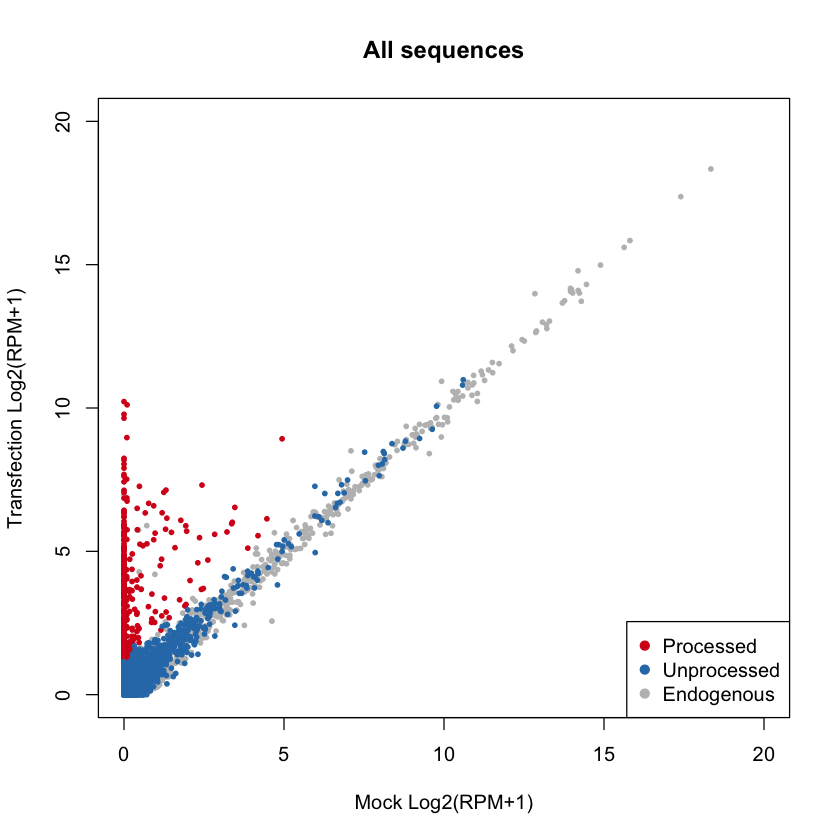

In [6]:
options(repr.plot.width=7, repr.plot.height=7)

hairpin_miRNA_RPM_x0_x1<-hairpin_miRNA_RPM[,grep("HEK",colnames(hairpin_miRNA_RPM))]
hairpin_miRNA_RPM_x0_x1<-hairpin_miRNA_RPM_x0_x1[,c(grep("mock_0x",colnames(hairpin_miRNA_RPM_x0_x1)),grep("sh.lib_1x",colnames(hairpin_miRNA_RPM_x0_x1)))]
hairpin_miRNA_RPM_x0_x1$mock_mean<-apply(hairpin_miRNA_RPM_x0_x1[,1:4],1,mean)
hairpin_miRNA_RPM_x0_x1$x1_mean<-apply(hairpin_miRNA_RPM_x0_x1[,5:8],1,mean)
hairpin_miRNA_RPM_x0_x1<-hairpin_miRNA_RPM_x0_x1[,c("mock_mean","x1_mean")]

hairpin_miRNA_RPM_x0_x1$label<-"grey"
hairpin_miRNA_RPM_x0_x1[rownames(hairpin_miRNA_RPM_x0_x1) %in% DE_oligos_hairpin_miRNA_HEK_mock.1x,]$label<-"#d7191c"
nonDE_oligos_hairpin_miRNA_HEK_mock.1x<-sh.lib_DNA_oligos_transfected.HEK[!sh.lib_DNA_oligos_transfected.HEK %in% DE_oligos_hairpin_miRNA_HEK_mock.1x]
hairpin_miRNA_RPM_x0_x1[rownames(hairpin_miRNA_RPM_x0_x1) %in% nonDE_oligos_hairpin_miRNA_HEK_mock.1x,]$label<-"#2c7bb6"

hairpin_miRNA_RPM_x0_x1$label<-factor(hairpin_miRNA_RPM_x0_x1$label,levels = c("grey","#d7191c","#2c7bb6"))
hairpin_miRNA_RPM_x0_x1<-hairpin_miRNA_RPM_x0_x1[order(hairpin_miRNA_RPM_x0_x1$label),]
hairpin_miRNA_RPM_x0_x1$label<-as.character(hairpin_miRNA_RPM_x0_x1$label)

plot(log2(hairpin_miRNA_RPM_x0_x1[,1]+1),log2(hairpin_miRNA_RPM_x0_x1[,2]+1),
     pch=19,col=hairpin_miRNA_RPM_x0_x1[,3],
     xlab="Mock Log2(RPM+1)", ylab="Transfection Log2(RPM+1)",xlim=c(0,20),ylim=c(0,20),cex=0.5,
     main="All sequences")
legend("bottomright",c("Processed","Unprocessed","Endogenous"),col=c("#d7191c","#2c7bb6","grey"),pch=c(19,19,19))


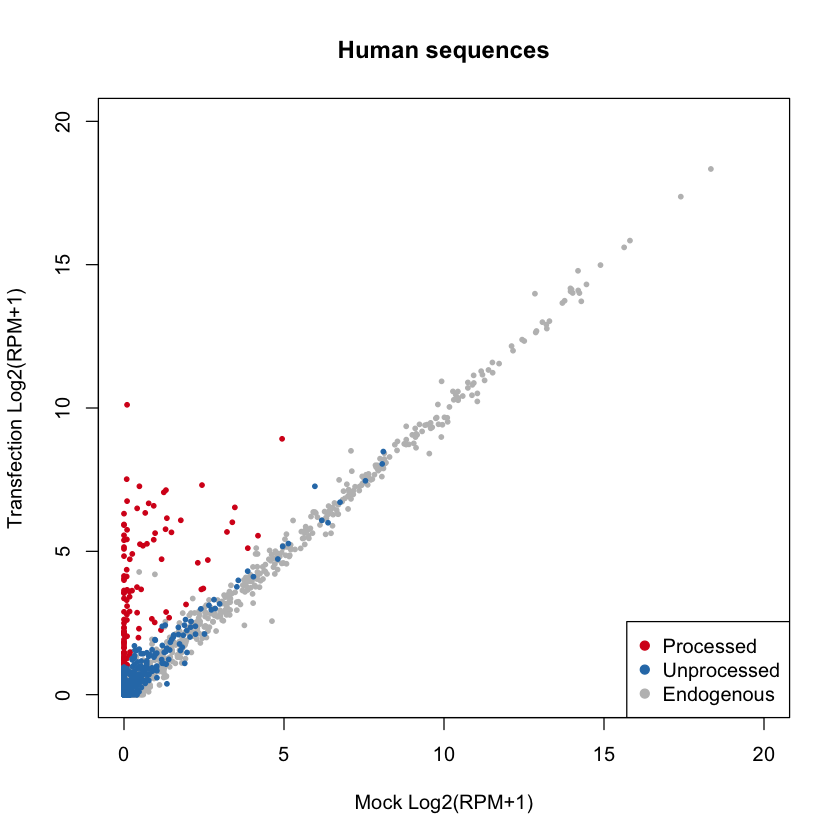

In [7]:
options(repr.plot.width=7, repr.plot.height=7)

hairpin_miRNA_RPM_x0_x1_sub_hsa<-hairpin_miRNA_RPM_x0_x1[grep("hsa",rownames(hairpin_miRNA_RPM_x0_x1)),]
plot(log2(hairpin_miRNA_RPM_x0_x1_sub_hsa[,1]+1),log2(hairpin_miRNA_RPM_x0_x1_sub_hsa[,2]+1),
     pch=19,col=hairpin_miRNA_RPM_x0_x1_sub_hsa[,3],
     xlab="Mock Log2(RPM+1)", ylab="Transfection Log2(RPM+1)",xlim=c(0,20),ylim=c(0,20),cex=0.5,
     main="Human sequences")
legend("bottomright",c("Processed","Unprocessed","Endogenous"),col=c("#d7191c","#2c7bb6","grey"),pch=c(19,19,19))


### Code related to Figure 2A

In [8]:
# load the quantifier data frame with considing multi mapping with both SciLifeLab and CRG samples
miRNA_countTable_from_quantifier<-read.table("./MapToCleave_supplemental_data/DataS5:count_table_of_MapToCleave_miRNA_precursors_for_cell_type_specific_processing_analysis.txt",sep="\t",header=TRUE)

miRNA_countTable_from_quantifier_1x<-miRNA_countTable_from_quantifier[,c(2,grep("_0x_.*1000ng",colnames(miRNA_countTable_from_quantifier)),
                                                                         grep("_1x_.*1000ng",colnames(miRNA_countTable_from_quantifier)),
                                                                         grep("_10x_.*1000ng",colnames(miRNA_countTable_from_quantifier)))]


miRNA_countTable_from_quantifier_1x$precursor<-as.character(miRNA_countTable_from_quantifier_1x$precursor)

In [9]:
#miRNA_countTable_from_quantifier[grep("hsa-mir-10a",miRNA_countTable_from_quantifier$precursor),]

for (i in 2:length(miRNA_countTable_from_quantifier_1x[1,])){
    if (length(grep("HEK|Hela",colnames(miRNA_countTable_from_quantifier_1x)[i]))!=0){
        miRNA_countTable_from_quantifier_1x[,i]<-miRNA_countTable_from_quantifier_1x[,i]/sum(miRNA_countTable_from_quantifier_1x[grep("hsa",miRNA_countTable_from_quantifier_1x$precursor),i])*10^6
    } else {
        miRNA_countTable_from_quantifier_1x[,i]<-miRNA_countTable_from_quantifier_1x[,i]/sum(miRNA_countTable_from_quantifier_1x[grep("mmu",miRNA_countTable_from_quantifier_1x$precursor),i])*10^6
    }
}

ids_DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb<-readLines("./MapToCleave_supplemental_data/DataS3:MapToCleave_processed_miRNA_precursor_IDs.txt")
ids_DE_oligos_hairpin_miRNA_NIH3T3_mock.1x_mirgenedb<-readLines("./data/ids_DE_oligos_hairpin_miRNA_NIH3T3_mock.1x_mirgenedb.txt")


ids_test<-c(ids_DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb,ids_DE_oligos_hairpin_miRNA_NIH3T3_mock.1x_mirgenedb)
ids_test<-gsub(":.*","",ids_test)

#test<-mirbase_name[mirbase_name$mirbase_name %in% miRNA_countTable_from_quantifier_1x$precursor,]
#test<-test[!test$mirgenedb=="NA",]
#ids_test<-test[test[,4] == "in",]$mirbase_name
#ids_test<-test$mirbase_name

miRNA_countTable_from_quantifier_1x_selected<-miRNA_countTable_from_quantifier_1x[miRNA_countTable_from_quantifier_1x$precursor %in% ids_test,]
miRNA_countTable_from_quantifier_1x_selected$precursor<-as.character(miRNA_countTable_from_quantifier_1x_selected$precursor)

In [10]:
ratio_out<-vector()
test_ids<-unique(miRNA_countTable_from_quantifier_1x_selected$precursor)
for (i in 1:length(test_ids)){

    tmp<-miRNA_countTable_from_quantifier_1x_selected[miRNA_countTable_from_quantifier_1x_selected$precursor == test_ids[i],]

    ratio<-vector()
    if (length(tmp[,1]) == 2){
       ratio<-unlist(tmp[1,2:length(tmp[1,])])+unlist(tmp[2,2:length(tmp[1,])])   
    } else if (length(tmp[,1]) == 1){
       ratio<-unlist(tmp[1,2:length(tmp[1,])])
        } else {
        ratio<-rep(NA,times=length(tmp[,2:length(tmp)]))
    }
    ratio_out<-rbind(ratio_out,ratio)
    #rownames(ratio_out)[i]<-ids_DE_oligos_hairpin_miRNA_HEK_mock.1xand10x_mirgenedb[i]
    rownames(ratio_out)[i]<-test_ids[i]
}

ratio_out<-data.frame(ratio_out)

ratio_out<-ratio_out[!is.na(ratio_out[,1]),]

In [11]:
## calculate processing efficiency
ratio_out$HEK_mock_mean<-apply(ratio_out[,1:4],1,mean)
ratio_out$NIH3T3_mock_mean<-apply(ratio_out[,5:8],1,mean)
ratio_out$HEK_x1_mean<-apply(ratio_out[,9:12],1,mean)
ratio_out$NIH3T3_x1_mean<-apply(ratio_out[,13:16],1,mean)
ratio_out$HEK_x10_mean<-apply(ratio_out[,17:20],1,mean)
ratio_out$diff_HEK<-ratio_out$HEK_x1_mean-ratio_out$HEK_mock_mean
ratio_out$diff_NIH3T3<-ratio_out$NIH3T3_x1_mean-ratio_out$NIH3T3_mock_mean
ratio_out$diff_HEK_x10<-ratio_out$HEK_x10_mean-ratio_out$HEK_mock_mean

ratio_out_RPM<-ratio_out

ratio_out<-ratio_out[,c("diff_HEK","diff_HEK_x10","diff_NIH3T3")]

In [12]:
head(ratio_out)

,diff_HEK,diff_HEK_x10,diff_NIH3T3
,<dbl>,<dbl>,<dbl>
cel-lin-4,21.175700,4.7920664,1.06626082
cel-mir-2208a,2.103966,0.2731792,0.25098927
cel-mir-233,6.283828,1.5802733,0.55730929
cel-mir-238,12.378191,2.1363152,0.80978452
cel-mir-242,3.173361,1.1587723,0.08099242
cel-mir-245,29.166068,2.4109210,2.54116678


In [13]:
# HEK vs NIH3T3

library(MASS)
library(ggplot2)
library(viridis)
library(RColorBrewer)

theme_set(theme_bw(base_size = 16))

get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}


ratio_out_HEK_vs_NIH3T3<-log2(ratio_out[,c("diff_HEK","diff_NIH3T3")])
ratio_out_HEK_vs_NIH3T3<-ratio_out_HEK_vs_NIH3T3[!is.na(ratio_out_HEK_vs_NIH3T3[,1]),]
ratio_out_HEK_vs_NIH3T3<-ratio_out_HEK_vs_NIH3T3[!is.infinite(ratio_out_HEK_vs_NIH3T3[,1]),]
ratio_out_HEK_vs_NIH3T3<-ratio_out_HEK_vs_NIH3T3[!is.na(ratio_out_HEK_vs_NIH3T3[,2]),]
ratio_out_HEK_vs_NIH3T3<-ratio_out_HEK_vs_NIH3T3[!is.infinite(ratio_out_HEK_vs_NIH3T3[,2]),]

ratio_out_HEK_vs_NIH3T3$density <- get_density(ratio_out_HEK_vs_NIH3T3$diff_HEK, ratio_out_HEK_vs_NIH3T3$diff_NIH3T3, n = 50)


res<-lm(formula = diff_NIH3T3 ~ diff_HEK, ratio_out_HEK_vs_NIH3T3)
ratio_out_HEK_vs_NIH3T3$res<-resid(res)
ratio_out_HEK_vs_NIH3T3$abs.sres<-abs(rstandard(res))


distance <- function(x,y,a,c){
    b <- -1
    d <- abs(a*x+b*y+c)/sqrt(a^2+b^2)
    return(d)
}

distance_d<-vector()

for (i in 1:length(ratio_out_HEK_vs_NIH3T3[,1])){
    distance_d<-c(distance_d,distance(ratio_out_HEK_vs_NIH3T3[i,][1],ratio_out_HEK_vs_NIH3T3[i,][2],coefficients(res)[2],coefficients(res)[1]))
}

ratio_out_HEK_vs_NIH3T3$distance<-unlist(distance_d)

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


Warning message in lapply(X = x, FUN = .Generic, ...):
“NaNs produced”
Warning message in lapply(X = x, FUN = .Generic, ...):
“NaNs produced”


In [14]:
head(ratio_out_HEK_vs_NIH3T3)

,diff_HEK,diff_NIH3T3,density,res,abs.sres,distance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cel-lin-4,4.404338,0.09256039,0.03189541,-0.59657604,0.37381229,0.43672135
cel-mir-2208a,1.073111,-1.99430241,0.02644585,0.41665677,0.26138234,0.30501209
cel-mir-233,2.651644,-0.84344989,0.02903489,0.09850042,0.06167433,0.07210688
cel-mir-238,3.629729,-0.30439003,0.03415518,-0.27266206,0.17072970,0.19960128
cel-mir-242,1.666011,-3.62606932,0.01487510,-1.76687304,1.10730142,1.29343307
cel-mir-245,4.866219,1.34549106,0.02960016,0.22652015,0.14203572,0.16582326


In [15]:
### HEK 1x vs. HEK 10x

ratio_out_HEK_vs_HEK<-log2(ratio_out[,c("diff_HEK","diff_HEK_x10")])
ratio_out_HEK_vs_HEK<-ratio_out_HEK_vs_HEK[!is.na(ratio_out_HEK_vs_HEK[,1]),]
ratio_out_HEK_vs_HEK<-ratio_out_HEK_vs_HEK[!is.infinite(ratio_out_HEK_vs_HEK[,1]),]
ratio_out_HEK_vs_HEK<-ratio_out_HEK_vs_HEK[!is.na(ratio_out_HEK_vs_HEK[,2]),]
ratio_out_HEK_vs_HEK<-ratio_out_HEK_vs_HEK[!is.infinite(ratio_out_HEK_vs_HEK[,2]),]

res<-lm(formula = diff_HEK_x10 ~ diff_HEK, ratio_out_HEK_vs_HEK)
coefficients(res)
ratio_out_HEK_vs_HEK$density <- get_density(ratio_out_HEK_vs_HEK$diff_HEK, ratio_out_HEK_vs_HEK$diff_HEK_x10, n = 50)

ratio_out_HEK_vs_HEK$res<-resid(res)
ratio_out_HEK_vs_HEK$abs.sres<-abs(rstandard(res))

distance <- function(x,y,a,c){
    b <- -1
    d <- abs(a*x+b*y+c)/sqrt(a^2+b^2)
    return(d)
}

distance_d<-vector()

for (i in 1:length(ratio_out_HEK_vs_HEK[,1])){
    distance_d<-c(distance_d,distance(ratio_out_HEK_vs_HEK[i,][1],ratio_out_HEK_vs_HEK[i,][2],coefficients(res)[2],coefficients(res)[1]))
}

ratio_out_HEK_vs_HEK$distance<-unlist(distance_d)

Warning message in lapply(X = x, FUN = .Generic, ...):
“NaNs produced”
Warning message in lapply(X = x, FUN = .Generic, ...):
“NaNs produced”


(Intercept)    diff_HEK 
  -2.086484    1.011349

In [16]:
ratio_out_HEK_vs_NIH3T3$group<-"HEK_vs_NIH3T3"
ratio_out_HEK_vs_NIH3T3$id<-rownames(ratio_out_HEK_vs_NIH3T3)
ratio_out_HEK_vs_HEK$group<-"HEK_vs_HEK"
ratio_out_HEK_vs_HEK$id<-rownames(ratio_out_HEK_vs_HEK)
colnames(ratio_out_HEK_vs_NIH3T3)[2]<-"diff_x"
colnames(ratio_out_HEK_vs_HEK)[2]<-"diff_x"

ratio_out_HEK_and_NIH3T3<-rbind(ratio_out_HEK_vs_NIH3T3,ratio_out_HEK_vs_HEK)


In [17]:
head(ratio_out_HEK_and_NIH3T3)

,diff_HEK,diff_x,density,res,abs.sres,distance,group,id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
cel-lin-4,4.404338,0.09256039,0.03189541,-0.59657604,0.37381229,0.43672135,HEK_vs_NIH3T3,cel-lin-4
cel-mir-2208a,1.073111,-1.99430241,0.02644585,0.41665677,0.26138234,0.30501209,HEK_vs_NIH3T3,cel-mir-2208a
cel-mir-233,2.651644,-0.84344989,0.02903489,0.09850042,0.06167433,0.07210688,HEK_vs_NIH3T3,cel-mir-233
cel-mir-238,3.629729,-0.30439003,0.03415518,-0.27266206,0.17072970,0.19960128,HEK_vs_NIH3T3,cel-mir-238
cel-mir-242,1.666011,-3.62606932,0.01487510,-1.76687304,1.10730142,1.29343307,HEK_vs_NIH3T3,cel-mir-242
cel-mir-245,4.866219,1.34549106,0.02960016,0.22652015,0.14203572,0.16582326,HEK_vs_NIH3T3,cel-mir-245


In [18]:
lm_HEK_vs_NIH3T3<-lm(formula = diff_x ~ diff_HEK, ratio_out_HEK_vs_NIH3T3)
lm_HEK_vs_HEK<-lm(formula = diff_x ~ diff_HEK, ratio_out_HEK_vs_HEK)
grey_lines<-rbind(coefficients(lm_HEK_vs_NIH3T3),coefficients(lm_HEK_vs_HEK))
grey_lines<-data.frame(grey_lines)
colnames(grey_lines)<-c("intercept","slop")
grey_lines$group<-c("HEK_vs_NIH3T3","HEK_vs_HEK")
grey_lines$group_new<-factor(grey_lines$group, levels=rev(c("HEK_vs_NIH3T3","HEK_vs_HEK")), labels=rev(c("HEK 1x vs. NIH3T3 1x","HEK 1x vs. HEK 10x"))) 
grey_lines

intercept,slop,group,group_new
<dbl>,<dbl>,<chr>,<fct>
-3.409615,0.9306169,HEK_vs_NIH3T3,HEK 1x vs. NIH3T3 1x
-2.086484,1.0113487,HEK_vs_HEK,HEK 1x vs. HEK 10x


### Plotting

`geom_smooth()` using formula 'y ~ x'



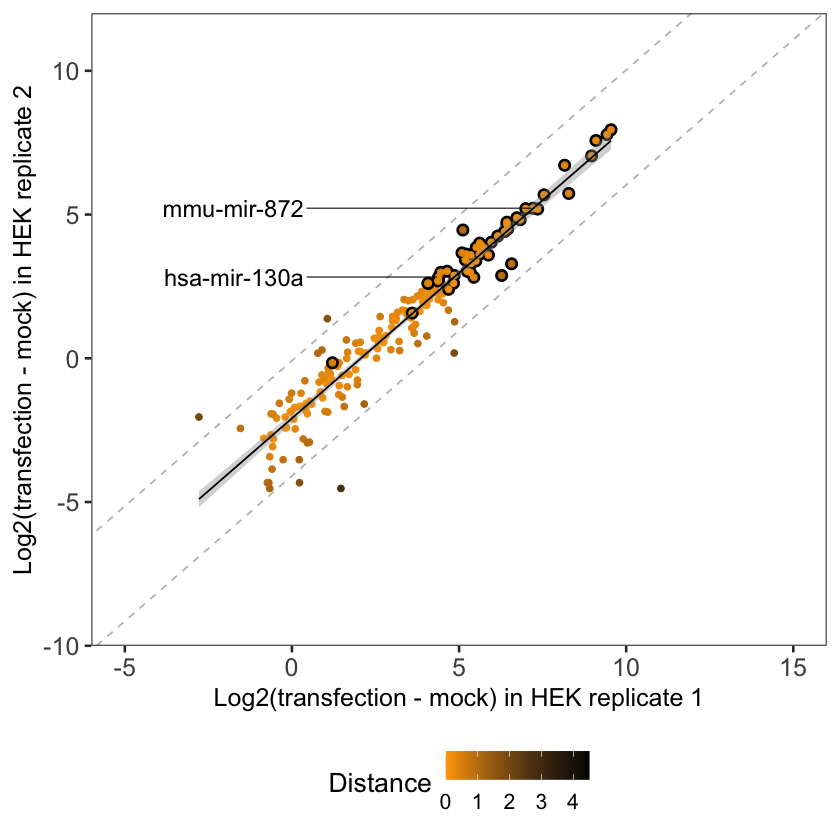

In [19]:
options(repr.plot.width=7, repr.plot.height=7)

library(ggrepel)

ratio_out_HEK_vs_HEK$distance_test<-ratio_out_HEK_vs_HEK$distance
ratio_out_HEK_vs_HEK[rownames(ratio_out_HEK_vs_HEK) %in% rownames(ratio_out_RPM)[which(ratio_out_RPM$HEK_x1_mean<6)],]$distance_test<-NA
ratio_out_HEK_vs_HEK[rownames(ratio_out_HEK_vs_HEK) %in% rownames(ratio_out_RPM)[which(ratio_out_RPM$HEK_x10_mean<6)],]$distance_test<-NA

ratio_out_subset<-ratio_out_HEK_and_NIH3T3[ratio_out_HEK_and_NIH3T3$id %in% c("mmu-mir-872","hsa-mir-130a"),]
ratio_out_subset2<-ratio_out_HEK_and_NIH3T3[ratio_out_HEK_and_NIH3T3$id %in% c("hsa-mir-483","hsa-mir-122"),]


ggplot(ratio_out_HEK_vs_HEK, aes(diff_HEK, diff_x)) + 
geom_point(data = ratio_out_HEK_vs_HEK[is.na(ratio_out_HEK_vs_HEK$distance_test),],aes(diff_HEK, diff_x, color = distance),size=1.5)+
geom_point(data = ratio_out_HEK_vs_HEK[!is.na(ratio_out_HEK_vs_HEK$distance_test),],aes(diff_HEK, diff_x),size=3,col="black")+
geom_point(data = ratio_out_HEK_vs_HEK[!is.na(ratio_out_HEK_vs_HEK$distance_test),],aes(diff_HEK, diff_x, color = distance),size=1.5)+
#geom_point(aes(diff_HEK, diff_x, color = distance),size=1.5) + 
scale_colour_gradient("Distance",low="orange", high="black", limits=c(0, 4.5)) +
geom_smooth(method='lm',color="black",size=0.5) + 
#facet_wrap(. ~ group_new,scales = "free")+
geom_abline(intercept = grey_lines[2,1]-2,slope = grey_lines[2,2],color="grey",linetype = "dashed")+
geom_abline(intercept = grey_lines[2,1]+2,slope = grey_lines[2,2],color="grey",linetype = "dashed")+
xlab("Log2(transfection - mock) in HEK replicate 1")+
ylab("Log2(transfection - mock) in HEK replicate 2")+
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      panel.background = element_blank(),axis.title=element_text(size=15),
      panel.border = element_rect(size=0.6, fill = NA),
      axis.text = element_text(size=15))+ theme(legend.position="bottom")+
xlim(c(-5,15))+ylim(c(-9,11))+
geom_text_repel(
    data = ratio_out_subset[ratio_out_subset$group == "HEK_vs_HEK",,drop=F],
    aes(label = id),
    size = 5,min.segment.length = 0, box.padding = 0.5,hjust = 1,
    nudge_x = 0 - ratio_out_subset[ratio_out_subset$group == "HEK_vs_HEK",,drop=F]$diff_HEK,
    segment.size = 0.3,
    direction = "y"
)

`geom_smooth()` using formula 'y ~ x'



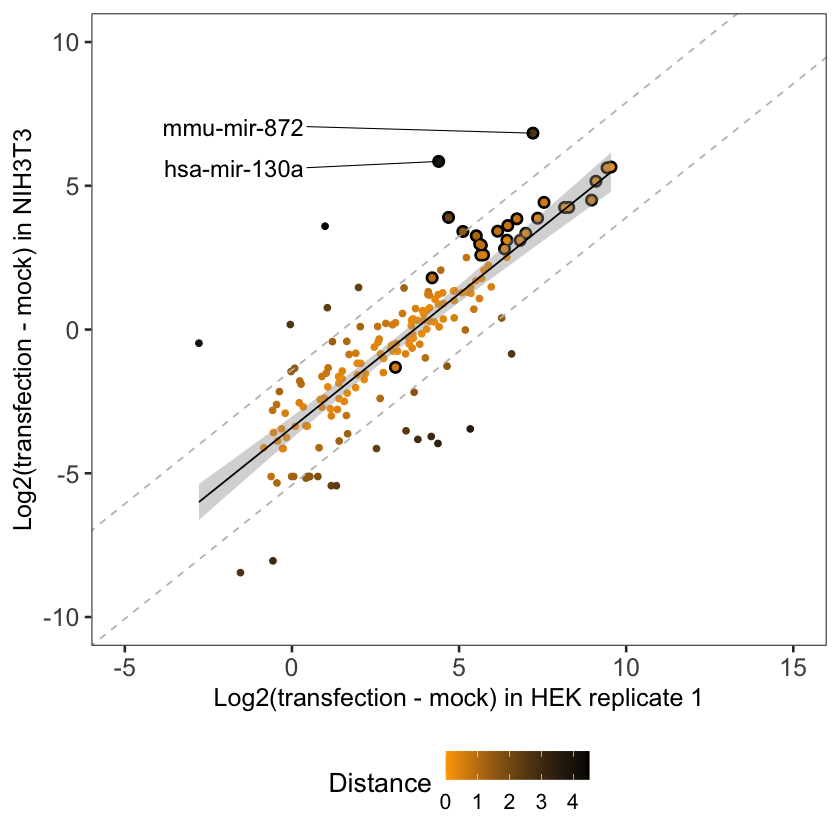

In [20]:
ratio_out_HEK_vs_NIH3T3$distance_test<-ratio_out_HEK_vs_NIH3T3$distance
ratio_out_HEK_vs_NIH3T3[rownames(ratio_out_HEK_vs_NIH3T3) %in% rownames(ratio_out_RPM)[which(ratio_out_RPM$HEK_x1_mean<6)],]$distance_test<-NA
ratio_out_HEK_vs_NIH3T3[rownames(ratio_out_HEK_vs_NIH3T3) %in% rownames(ratio_out_RPM)[which(ratio_out_RPM$NIH3T3_x1_mean<6)],]$distance_test<-NA


ggplot(ratio_out_HEK_vs_NIH3T3, aes(diff_HEK, diff_x)) + 
geom_point(data = ratio_out_HEK_vs_NIH3T3[is.na(ratio_out_HEK_vs_NIH3T3$distance_test),],aes(diff_HEK, diff_x, color = distance),size=1.5)+
geom_point(data = ratio_out_HEK_vs_NIH3T3[!is.na(ratio_out_HEK_vs_NIH3T3$distance_test),],aes(diff_HEK, diff_x),size=3,col="black")+
geom_point(data = ratio_out_HEK_vs_NIH3T3[!is.na(ratio_out_HEK_vs_NIH3T3$distance_test),],aes(diff_HEK, diff_x, color = distance),size=1.5)+
#geom_point(aes(diff_HEK, diff_x, color = distance),size=1.5) + 
scale_colour_gradient("Distance",low="orange", high="black", limits=c(0, 4.5)) +
geom_smooth(method='lm',color="black",size=0.5) + 
#facet_wrap(. ~ group_new,scales = "free")+
geom_abline(intercept = grey_lines[1,1]-2,slope = grey_lines[1,2],color="grey",linetype = "dashed")+
geom_abline(intercept = grey_lines[1,1]+2,slope = grey_lines[1,2],color="grey",linetype = "dashed")+
xlab("Log2(transfection - mock) in HEK replicate 1")+
ylab("Log2(transfection - mock) in NIH3T3")+
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      panel.background = element_blank(),axis.title=element_text(size=15),
      panel.border = element_rect(size=0.6, fill = NA),
      axis.text = element_text(size=15))+ theme(legend.position="bottom")+
xlim(c(-5,15))+ylim(c(-10,10))+
#geom_text(data = ratio_out_subset,aes(label = id),size=4,vjust = 0,nudge_x = 0,nudge_y = 0.2)
geom_text_repel(
    data = ratio_out_subset[ratio_out_subset$group == "HEK_vs_NIH3T3",,drop=F],
    aes(label = id),
    size = 5,min.segment.length = 0, box.padding = 0.5,hjust = 1,
    nudge_x = 0 - ratio_out_subset[ratio_out_subset$group == "HEK_vs_NIH3T3",,drop=F]$diff_HEK,
    segment.size = 0.3,
    direction = "y"
)

### Code related to Figure 2B

In [21]:
df_summary_mirbase_and_mirgenedb<-df_summary[-grep("hsa|mmu|dme|cel",df_summary$type),]
df_summary_mirbase_and_mirgenedb<-rbind(df_summary_mirgenedb,df_summary_mirbase_and_mirgenedb)
df_summary_mirbase_and_mirgenedb<-df_summary_mirbase_and_mirgenedb[-grep("NA|can|exo|int|ndi",df_summary_mirbase_and_mirgenedb$type),]

rownames(df_summary_mirbase_and_mirgenedb)<-df_summary_mirbase_and_mirgenedb[,1]
df_summary_mirbase_and_mirgenedb[,1]<-NULL

df_summary_mirbase_and_mirgenedb<-df_summary_mirbase_and_mirgenedb[c("hsa","mmu","dme","cel","sme","nve","aqu","ddi","cre","ath","con","per"),]
df_summary_mirbase_and_mirgenedb<-t(df_summary_mirbase_and_mirgenedb)
tmp_table<-df_summary_mirbase_and_mirgenedb

tmp_table<-tmp_table[c("DNA_oligos_transfected_in_HEK","DE_oligos_in_HEK_1xand10x.0x"),]

tmp_table<-t(tmp_table)
tmp_table[,2]<-tmp_table[,2]/tmp_table[,1]*100
tmp_table[,1]<-tmp_table[,1]/tmp_table[,1]*100

tmp_table[is.na(tmp_table)]<-0

row_names<-c("Human","Mouse","Fruit fly","Nematode","Planarian","Sea\nanemone","Sponge","Slime mold","Single-cell\ngreen alga","Thale cress","Control","Permuted")
rownames(tmp_table)<-row_names

#### Get the presence of known motifs in processed and unprocessed MapToCleave miRNA precursors

In [22]:
# load the ids of processed and unprocessed MapToCleave miRNA precursors
processed_ids<-readLines("./MapToCleave_supplemental_data/DataS3:MapToCleave_processed_miRNA_precursor_IDs.txt")
unprocessed_ids<-readLines("./MapToCleave_supplemental_data/DataS4:MapToCleave_unprocessed_miRNA_precursor_IDs.txt")

# load the presence of known motifs
n<-1

for (i in c(processed_ids,unprocessed_ids)){
    f <- paste("./MapToCleave_supplemental_data/detailed_feature_profile_of_MapToCleave_processed_and_unprocessed_miRNA_precursors/",i,".HEK.motif",sep="")
    if (file.exists(f)){
        tmp<-read.table(f,sep="\t",row.names=1)
        colnames(tmp)<-i
        if (n == 1){
            motif<-tmp
        } else {
            motif<-cbind(motif,tmp)            
        }        
        n<-n+1
    }
}

motif<-data.frame(t(motif))


In [23]:
### the presence of known motifs in processed and unprocessed MapToCleave miRNA precursors

# load ids for processed hairpins
df_summary_ids_DE_mirgenedb<-DE_oligos_hairpin_miRNA_HEK_mock.1x_mirgenedb
df_summary_ids_nonDE_mirgenedb<-sh.lib_DNA_oligos_transfected.HEK_mirgenedb[!sh.lib_DNA_oligos_transfected.HEK_mirgenedb %in% df_summary_ids_DE_mirgenedb]
df_summary_ids_mirgenedb<-c(df_summary_ids_DE_mirgenedb,df_summary_ids_nonDE_mirgenedb)

df_summary_ids_DE<-DE_oligos_hairpin_miRNA_HEK_mock.1x
df_summary_ids_nonDE<-sh.lib_DNA_oligos_transfected.HEK[!sh.lib_DNA_oligos_transfected.HEK %in% df_summary_ids_DE]
df_summary_ids<-c(df_summary_ids_DE,df_summary_ids_nonDE)


checked_motifs<-c("UG_atBasalJunction","UGUorGUG_atApicalJunction","GHG_at_3pBasalStem","CNNC_at3pFlanking")

# using ids existing in mirgenedb
species_mirgenedb<-c("hsa","mmu","dme","cel")
motif_presence_mirgenedb<-vector()

for (i in 1:length(checked_motifs)){
    tmp_out_DE<-vector()
    tmp_out_nonDE<-vector()
    for (j in species_mirgenedb){

    tmp<-motif[rownames(motif) %in% df_summary_ids_DE_mirgenedb[grep(j,df_summary_ids_DE_mirgenedb)],][,checked_motifs[i],drop=F]
    tmp<-tmp[!is.na(tmp[,1]),,drop=F]
    tmp<-length(which(tmp[,1]==1))/length(which(!is.na(tmp[,1])))*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)


    tmp<-motif[rownames(motif) %in% df_summary_ids_nonDE_mirgenedb[grep(j,df_summary_ids_nonDE_mirgenedb)],][,checked_motifs[i],drop=F]
    tmp<-tmp[!is.na(tmp[,1]),,drop=F]
    tmp<-length(which(tmp[,1]==1))/length(which(!is.na(tmp[,1])))*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)
    }

    motif_presence_mirgenedb<-cbind(motif_presence_mirgenedb,tmp_out_nonDE)
    colnames(motif_presence_mirgenedb)[length(motif_presence_mirgenedb[1,])]<-paste(checked_motifs[i],"_A",sep="")
    motif_presence_mirgenedb<-cbind(motif_presence_mirgenedb,tmp_out_DE)
    colnames(motif_presence_mirgenedb)[length(motif_presence_mirgenedb[1,])]<-paste(checked_motifs[i],"_B",sep="")

    
}

# using ids existing in miRBase
species<-c("hsa","mmu","dme","cel","sme","nve","aqu","ddi","cre")
motif_presence<-vector()


for (i in 1:length(checked_motifs)){
    tmp_out_DE<-vector()
    tmp_out_nonDE<-vector()
    for (j in species){

    tmp<-motif[rownames(motif) %in% df_summary_ids_DE[grep(j,df_summary_ids_DE)],][,checked_motifs[i],drop=F]
    tmp<-tmp[!is.na(tmp[,1]),,drop=F]
    tmp<-length(which(tmp[,1]==1))/length(which(!is.na(tmp[,1])))*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)


    tmp<-motif[rownames(motif) %in% df_summary_ids_nonDE[grep(j,df_summary_ids_nonDE)],][,checked_motifs[i],drop=F]
    tmp<-tmp[!is.na(tmp[,1]),,drop=F]
    tmp<-length(which(tmp[,1]==1))/length(which(!is.na(tmp[,1])))*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)
    }

    motif_presence<-cbind(motif_presence,tmp_out_nonDE)
    colnames(motif_presence)[length(motif_presence[1,])]<-paste(checked_motifs[i],"_A",sep="")
    motif_presence<-cbind(motif_presence,tmp_out_DE)
    colnames(motif_presence)[length(motif_presence[1,])]<-paste(checked_motifs[i],"_B",sep="")
    
}

motif_presence_mirgenedb<-rbind(motif_presence_mirgenedb,motif_presence[5:9,])

motif_presence_mirgenedb<-rbind(motif_presence_mirgenedb,rep(NA,times=8))
rownames(motif_presence_mirgenedb)[length(motif_presence_mirgenedb[,1])]<-"ath"
motif_presence_mirgenedb

,UG_atBasalJunction_A,UG_atBasalJunction_B,UGUorGUG_atApicalJunction_A,UGUorGUG_atApicalJunction_B,GHG_at_3pBasalStem_A,GHG_at_3pBasalStem_B,CNNC_at3pFlanking_A,CNNC_at3pFlanking_B
hsa,28.76712,27.02703,58.10811,51.35135,20.000000,30.76923,69.565217,75.71429
mmu,40.54054,41.81818,24.32432,41.81818,24.242424,22.00000,69.444444,74.07407
dme,26.08696,32.07547,36.17021,56.60377,25.581395,34.78261,71.794872,81.81818
cel,19.10112,30.00000,14.60674,15.00000,13.750000,20.00000,8.988764,25.00000
sme,23.30097,25.00000,22.33010,25.00000,7.792208,0.00000,74.117647,75.00000
nve,31.25000,0.00000,15.62500,50.00000,7.142857,0.00000,13.793103,0.00000
aqu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ddi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ath,NA,NA,NA,NA,NA,NA,NA,NA


#### Get the presence of stable lower basal stem in the processed and unprocessed MapToCleave miRNA precursors

In [24]:
### the presence of stable lower basal stem in the processed and unprocessed MapToCleave miRNA precursors

df_energy_7mer<-stemscan_7_mer

lower_basal_stem_presence<-df_energy_7mer
lower_basal_stem_presence<-t(lower_basal_stem_presence)
lower_basal_stem_presence<-data.frame(lower_basal_stem_presence,check.names = F)


checked_motifs<-c("-14","-13")
i<-2

#for (n in seq(-5,0,0.1)){
#    print(n)

# using ids existing in mirgenedb
species_mirgenedb<-c("hsa","mmu","dme","cel")
LSB_presence_mirgenedb<-vector()



tmp_out_DE<-vector()
tmp_out_nonDE<-vector()

    j="hsa"
    cut_off <- -2.3
    #cut_off <- n

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE_mirgenedb[grep(j,df_summary_ids_DE_mirgenedb)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]    
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)

    
    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE_mirgenedb[grep(j,df_summary_ids_nonDE_mirgenedb)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)


    j="mmu"
    cut_off <- -1.8
    #cut_off <- n

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE_mirgenedb[grep(j,df_summary_ids_DE_mirgenedb)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]    
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)

    
    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE_mirgenedb[grep(j,df_summary_ids_nonDE_mirgenedb)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)



    j="dme"
    cut_off <- -1.3
    #cut_off <- n

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE_mirgenedb[grep(j,df_summary_ids_DE_mirgenedb)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]    
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)

    
    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE_mirgenedb[grep(j,df_summary_ids_nonDE_mirgenedb)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)



    j="cel"
    cut_off <- -2
    #cut_off <- n

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE_mirgenedb[grep(j,df_summary_ids_DE_mirgenedb)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]    
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)

    
    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE_mirgenedb[grep(j,df_summary_ids_nonDE_mirgenedb)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)


LSB_presence_mirgenedb<-cbind(LSB_presence_mirgenedb,tmp_out_nonDE)
colnames(LSB_presence_mirgenedb)[length(LSB_presence_mirgenedb[1,])]<-paste(checked_motifs[i],"_A",sep="")
LSB_presence_mirgenedb<-cbind(LSB_presence_mirgenedb,tmp_out_DE)
colnames(LSB_presence_mirgenedb)[length(LSB_presence_mirgenedb[1,])]<-paste(checked_motifs[i],"_B",sep="")
#LSB_presence_mirgenedb
    

# using ids existing in miRBase
species<-c("hsa","mmu","dme","cel","sme","nve","aqu","ddi","cre")
LSB_presence<-vector()

tmp_out_DE<-vector()
tmp_out_nonDE<-vector()

#for (j in species){
    j = "sme"
    cut_off <- -1.9
    #cut_off <- n

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE[grep(j,df_summary_ids_DE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,1]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)


    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE[grep(j,df_summary_ids_nonDE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,1]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)

    j = "nve"
    cut_off <- -4.2
    #cut_off <- n

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE[grep(j,df_summary_ids_DE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)


    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE[grep(j,df_summary_ids_nonDE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,2]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)

    j = "aqu"
    cut_off <- -4.8

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE[grep(j,df_summary_ids_DE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,1]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)


    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE[grep(j,df_summary_ids_nonDE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,1]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)

    j = "ddi"
    cut_off <- -4.8

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE[grep(j,df_summary_ids_DE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,1]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)


    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE[grep(j,df_summary_ids_nonDE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,1]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)

    j = "cre"
    cut_off <- -4.8

    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_DE[grep(j,df_summary_ids_DE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,1]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_DE<-c(tmp_out_DE,tmp)


    tmp<-lower_basal_stem_presence[rownames(lower_basal_stem_presence) %in% df_summary_ids_nonDE[grep(j,df_summary_ids_nonDE)],][,c(checked_motifs[1],checked_motifs[2]),drop=F]
    tmp$min<-apply(tmp,1,min)
    tmp$min<-tmp[,1]
    tmp<-tmp[!is.na(tmp$min),,drop=F]
    tmp<-length(which(tmp$min < cut_off))/length(tmp[,1])*100
    names(tmp)<-j
    tmp_out_nonDE<-c(tmp_out_nonDE,tmp)
#}

LSB_presence<-cbind(LSB_presence,tmp_out_nonDE)
colnames(LSB_presence)[length(LSB_presence[1,])]<-paste(checked_motifs[i],"_A",sep="")
LSB_presence<-cbind(LSB_presence,tmp_out_DE)
colnames(LSB_presence)[length(LSB_presence[1,])]<-paste(checked_motifs[i],"_B",sep="")

lower_basal_stem_presence_mirgenedb<-rbind(LSB_presence_mirgenedb,LSB_presence)


# put NA for aqu, ddi, cre, since they only have few 
lower_basal_stem_presence_mirgenedb["aqu",] <- NA
lower_basal_stem_presence_mirgenedb["ddi",] <- NA
lower_basal_stem_presence_mirgenedb["cre",] <- NA
lower_basal_stem_presence_mirgenedb<-rbind(lower_basal_stem_presence_mirgenedb,rep(NA,times=2))
rownames(lower_basal_stem_presence_mirgenedb)[length(lower_basal_stem_presence_mirgenedb[,1])]<-"ath"
lower_basal_stem_presence_mirgenedb
#   }


,-13_A,-13_B
hsa,58.10811,79.72973
mmu,55.55556,78.18182
dme,48.93617,64.15094
cel,17.04545,50.00000
sme,40.19608,75.00000
nve,16.66667,100.00000
aqu,NA,NA
ddi,NA,NA
cre,NA,NA
ath,NA,NA


#### Plotting

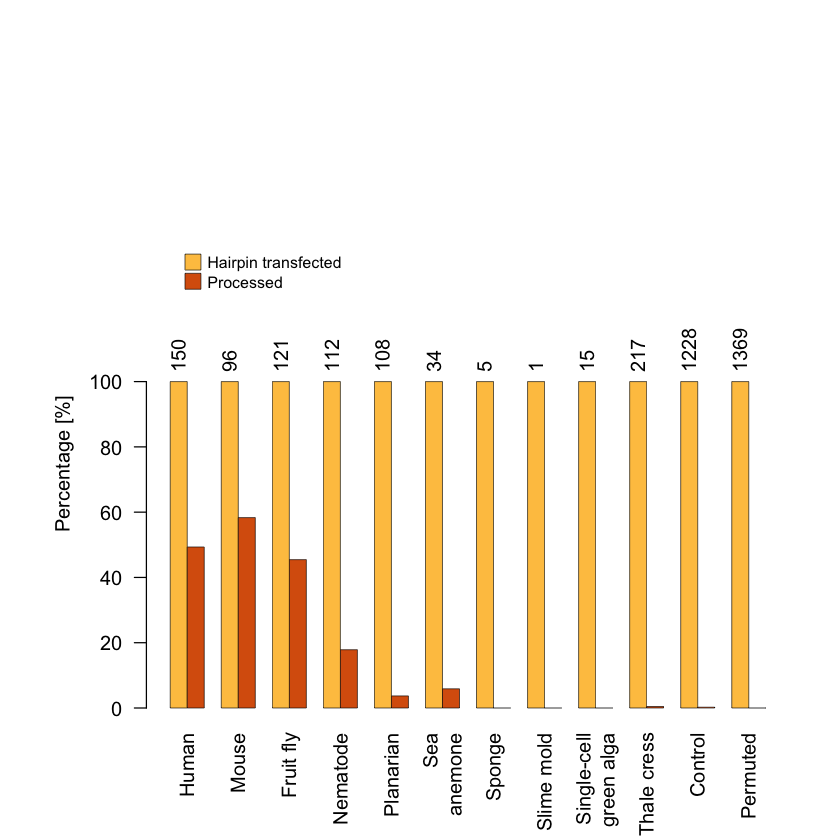

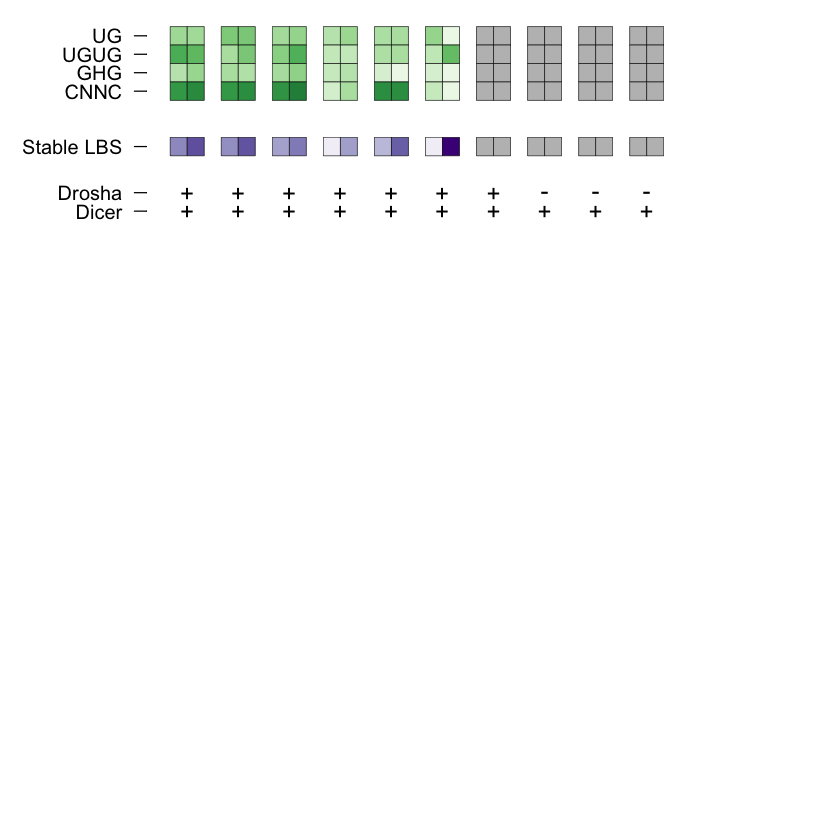

In [25]:
options(repr.plot.width=7, repr.plot.height=7)

library(pheatmap)

lty.o <- par("lty")
par(lty = 1,lwd=0.5)

#par(mfcol = c(2, 1))
par(mar=c(5.5,6.1,9.1,2.1))

coor<-barplot(as.matrix(t(tmp_table)),col=c('#fec44f','#d95f0e'),las=1,beside = TRUE,las=2,
              ylab="Percentage [%]",ylim = c(0,150),
              yaxt = 'n')
text(coor[seq(1,24,2)],103,df_summary_mirbase_and_mirgenedb["DNA_oligos_transfected_in_HEK",],srt=90,adj=0)
axis(2, at=seq(0,100,20), labels=seq(0,100,20), tick=TRUE, las=2, line=0, cex.axis=1)

legend("topleft", legend = c("Hairpin transfected","Processed") , pch=22,
       pt.bg = c('#fec44f','#d95f0e'), 
       col = c('black','black'),
       bty = "n", pt.cex = 2, cex = 0.8, horiz = FALSE, inset = c(0.05, 0.05))


# get color for the heatmap of motif presence
motif_presence_mirgenedb["cre","CNNC_at3pFlanking_A"]<-100
A<-motif_presence_mirgenedb
#pal <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name = "RdYlBu")))(100)
pal <- colorRampPalette(RColorBrewer::brewer.pal(n = 7, name = "Greens"))(100)
bks <- pheatmap:::generate_breaks(A, length(pal), center = F)
A2 <- pheatmap:::scale_colours(A, col=pal, breaks=bks,na_col="grey")

A2<-data.frame(A2,check.names = F)
A2["aqu",] <- "grey"
A2["ddi",] <- "grey"
A2["cre",] <- "grey"
A2<-as.matrix(A2)

par(mar=c(5.1,6.1,0,2.1))
plot(1, type="n", xlab="", ylab="", xlim=c(1, max(coor)+0.5), ylim=c((max(coor)+0.5)*(-1), 0), axes=FALSE)
number<-sort(c(seq(1,28,3), seq(2,29,3)))

A2_selected<-t(A2[,1:2])
for (i in 1:length(number)){  
    polygon(x = c(number[i], number[i]+1, number[i]+1, number[i]),                           # X-Coordinates of polygon
        y = c(0, 0, -1, -1),                             # Y-Coordinates of polygon
        col = array(A2_selected)[i])   
}

A2_selected<-t(A2[,3:4])
for (i in 1:length(number)){  
    polygon(x = c(number[i], number[i]+1, number[i]+1, number[i]),                           # X-Coordinates of polygon
        y = c(-1, -1, -2, -2),                             # Y-Coordinates of polygon
        col = array(A2_selected)[i])   
}

A2_selected<-t(A2[,5:6])
for (i in 1:length(number)){  
    polygon(x = c(number[i], number[i]+1, number[i]+1, number[i]),                           # X-Coordinates of polygon
        y = c(-2, -2, -3, -3),                             # Y-Coordinates of polygon
        col = array(A2_selected)[i])   
}

A2_selected<-t(A2[,7:8])
for (i in 1:length(number)){  
    polygon(x = c(number[i], number[i]+1, number[i]+1, number[i]),                           # X-Coordinates of polygon
        y = c(-3, -3, -4, -4),                             # Y-Coordinates of polygon
        col = array(A2_selected)[i])   
}

axis(2,at=-0.5,labels = "UG",las=2)
axis(2,at=-1.5,labels = "UGUG",las=2)
axis(2,at=-2.5,labels = "GHG",las=2)
axis(2,at=-3.5,labels = "CNNC",las=2)


# get color for the heatmap of stable lower basal stem presence
A<-lower_basal_stem_presence_mirgenedb
#pal <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 7, name = "RdYlBu")))(100)
pal <- colorRampPalette(RColorBrewer::brewer.pal(n = 7, name = "Purples"))(100)
#pal <- colorRampPalette(RColorBrewer::brewer.pal(n = 7, name = "Greens"))(100)
bks <- pheatmap:::generate_breaks(A, length(pal), center = F)
A2 <- pheatmap:::scale_colours(A, col=pal, breaks=bks,na_col="grey")

A2_selected<-t(A2[,1:2])
for (i in 1:length(number)){  
    polygon(x = c(number[i], number[i]+1, number[i]+1, number[i]),                           # X-Coordinates of polygon
        y = c(-6, -6, -7, -7),                             # Y-Coordinates of polygon
        col = array(A2_selected)[i])   
}

axis(2,at=-6.5,labels = "Stable LBS",las=2)

# the presence of Drosha
presence_drosha<-c("+","+","+","+","+","+","+","-","-","-")
presence_dicer<-c("+","+","+","+","+","+","+","+","+","+")

for (i in 1:length(presence_drosha)){
    if (i == 1){
        n <- i+1
    }
    text(n,-9,presence_drosha[i],cex = 1.2)    
    text(n,-10,presence_dicer[i],cex = 1.2)  
    n<-n+3
}
axis(2,at=-9,labels = "Drosha",las=2)
axis(2,at=-10,labels = "Dicer",las=2)

#dev.off()

### Code related to Figure 3

In [26]:
# load the ids of processed and unprocessed MapToCleave miRNA precursors
processed_ids<-readLines("./MapToCleave_supplemental_data/DataS3:MapToCleave_processed_miRNA_precursor_IDs.txt")
unprocessed_ids<-readLines("./MapToCleave_supplemental_data/DataS4:MapToCleave_unprocessed_miRNA_precursor_IDs.txt")


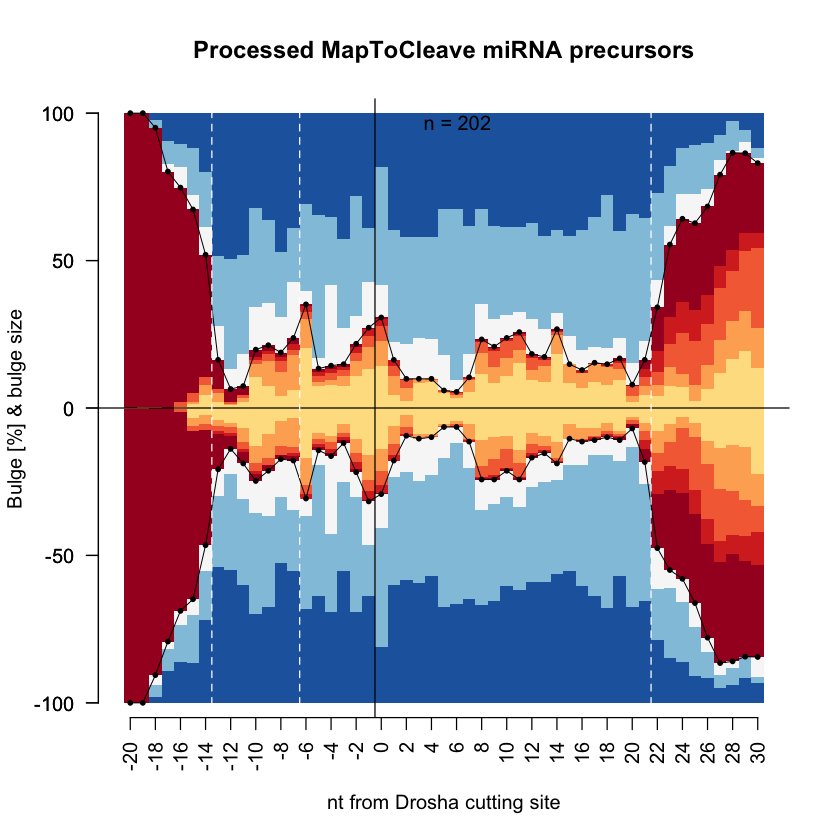

In [27]:
options(repr.plot.width=7, repr.plot.height=7)

# the structure profile of processed MapToCleave miRNA precursors (related to Figure 3)
processed_ids_hsa_mmu_dme_cel<-processed_ids[grep("hsa|mmu|dme|cel",processed_ids)]
dumbbell_heat_plot(processed_ids_hsa_mmu_dme_cel,"Processed MapToCleave miRNA precursors")

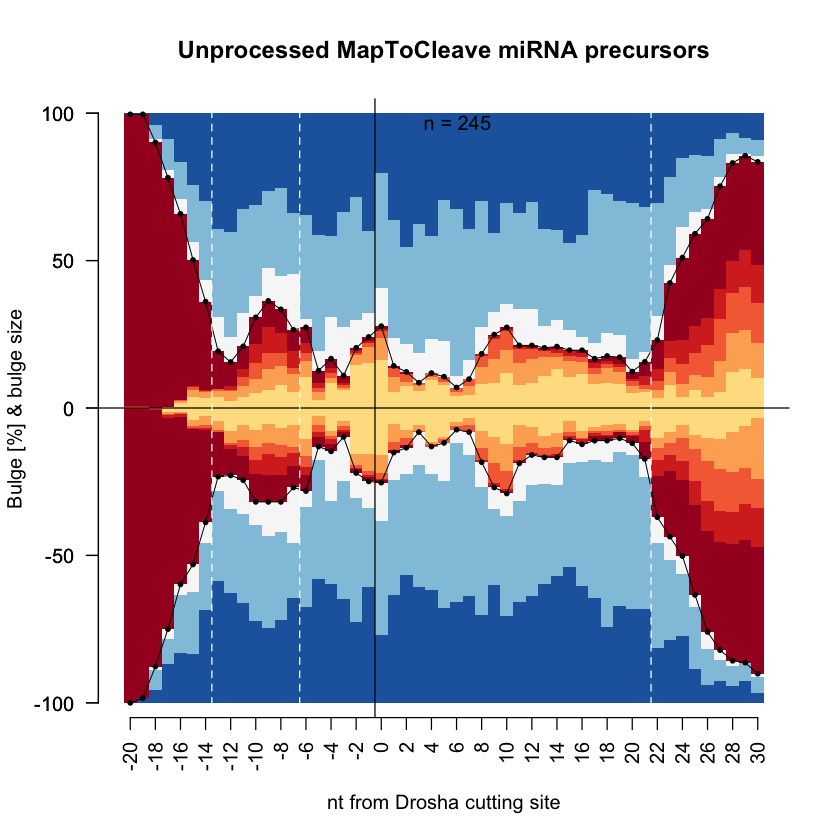

In [28]:
options(repr.plot.width=7, repr.plot.height=7)

# the structure profile of unprocessed MapToCleave miRNA precursors (related to Figure 3)
unprocessed_ids_hsa_mmu_dme_cel<-unprocessed_ids[grep("hsa|mmu|dme|cel",unprocessed_ids)]
dumbbell_heat_plot(unprocessed_ids_hsa_mmu_dme_cel,"Unprocessed MapToCleave miRNA precursors")

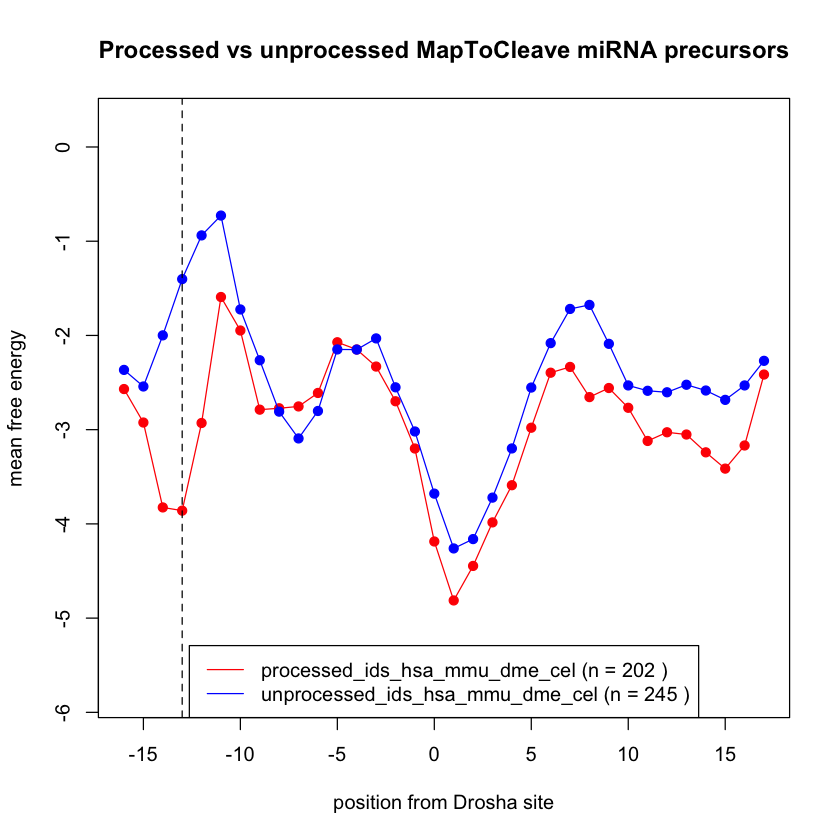

In [29]:
options(repr.plot.width=7, repr.plot.height=7)
local_stability_plot(stemscan_7_mer,processed_ids_hsa_mmu_dme_cel,unprocessed_ids_hsa_mmu_dme_cel,"Processed vs unprocessed MapToCleave miRNA precursors")

### Code related to Figure 5

In [30]:
### get normalized data table 

df<-read.table("./MapToCleave_supplemental_data/DataS11:count_table_for_experimental_validation.txt",sep="\t",header=TRUE,check.names = FALSE)


df_hairpin<-df[,3:length(df[1,])]
ids<-as.character(unique(df_hairpin$precursor))

out<-vector
for (i in 1:length(ids)){
  tmp<-df_hairpin[df_hairpin$precursor==ids[i],]
  if (length(tmp[,1])>=1){
    tmptmp<-apply(tmp[,2:length(tmp[1,])], 2, sum)
  } else {
    tmptmp<-tmp
  }
  
  if (i == 1){
    out<-tmptmp
  } else {
    out<-rbind(out,tmptmp)
  }
}

rownames(out)<-ids
df_hairpin<-out

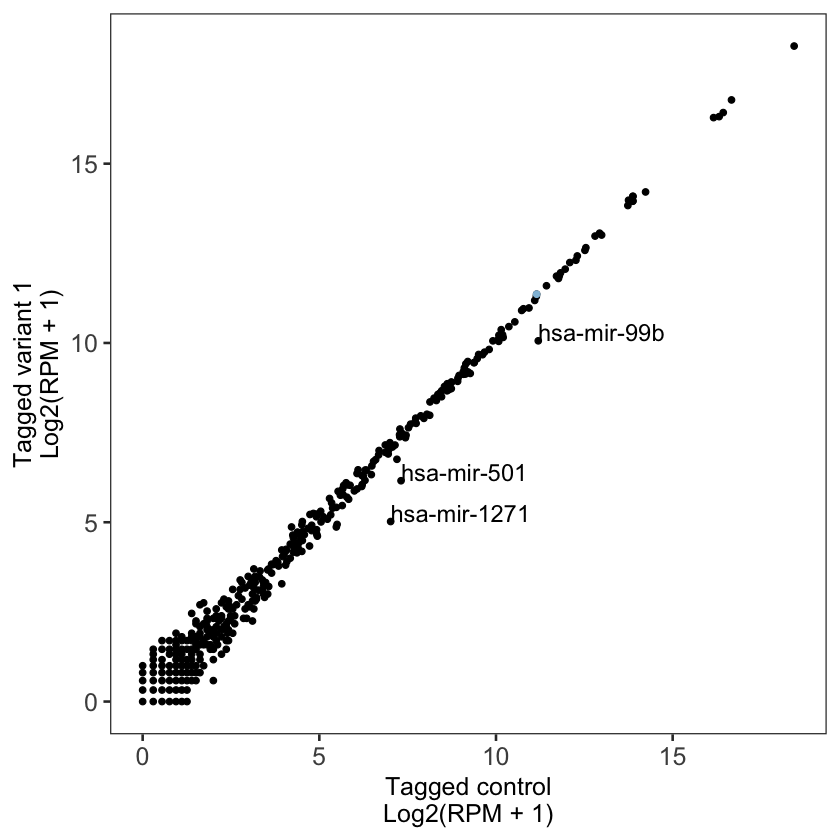

In [31]:
# scatter plot between S02 and S06
library(ggplot2)

df_hairpin_control_vs_test<-df_hairpin[,c("S02","S06")]

## remove the redundant tagged hairpins, such as mir-160001, mir-160002, mir-160003, mir-160004, mir-30001a, mir-30002a, mir-30003a and mir-30004a

ids_to_remove<-c(rownames(df_hairpin_control_vs_test)[grep("1600[1-4].*tagged.*",rownames(df_hairpin_control_vs_test))],
rownames(df_hairpin_control_vs_test)[grep("3000[1-4].*tagged.*",rownames(df_hairpin_control_vs_test))])

df_hairpin_control_vs_test<-df_hairpin_control_vs_test[!rownames(df_hairpin_control_vs_test) %in% ids_to_remove,]

for (i in 1:length(df_hairpin_control_vs_test[1,])){
    df_hairpin_control_vs_test[,i]<-df_hairpin_control_vs_test[,i]/sum(df_hairpin_control_vs_test[,i])*10^6
}


df_hairpin_control_vs_test_log<-log2(df_hairpin_control_vs_test+1)
df_hairpin_control_vs_test_log<-data.frame(df_hairpin_control_vs_test_log)
df_hairpin_control_vs_test_log$group_new<-"S01 vs S06"

## ggplot

#pdf("For_figure_tmp.pdf",width = 4,height = 4)

ids_selected<-rownames(df_hairpin_control_vs_test[order((df_hairpin_control_vs_test[,"S06"]+1)/(df_hairpin_control_vs_test[,"S02"]+1),decreasing = F),][1:5,])
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log[rownames(df_hairpin_control_vs_test_log) %in% ids_selected,]
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log_selected[df_hairpin_control_vs_test_log_selected$S06 > 5,]

### simplified bin plot
library(hexbin)
bin<-hexbin(df_hairpin_control_vs_test_log$S02, df_hairpin_control_vs_test_log$S06, xbins=200,IDs= TRUE)
df_bin<-data.frame(bin@xcm,bin@ycm)
colnames(df_bin)<-c("S02","S06")

ggplot(df_bin,aes(x=S02, y=S06)) + 
geom_point()+
geom_point(data = df_hairpin_control_vs_test_log[grep("16000-",rownames(df_hairpin_control_vs_test_log)),],aes(S02, S06),col="#91bfdb")+
geom_text(data = df_hairpin_control_vs_test_log_selected, aes(label = rownames(df_hairpin_control_vs_test_log_selected)),size=5, vjust = 0, hjust= 0 ,nudge_x = 0,nudge_y = 0)+
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      panel.background = element_blank(),axis.title=element_text(size=15),
      panel.border = element_rect(size=0.7, fill = NA),
      axis.text = element_text(size=15))+
xlab("Tagged control\nLog2(RPM + 1)")+
ylab("Tagged variant 1\nLog2(RPM + 1)")

#dev.off()

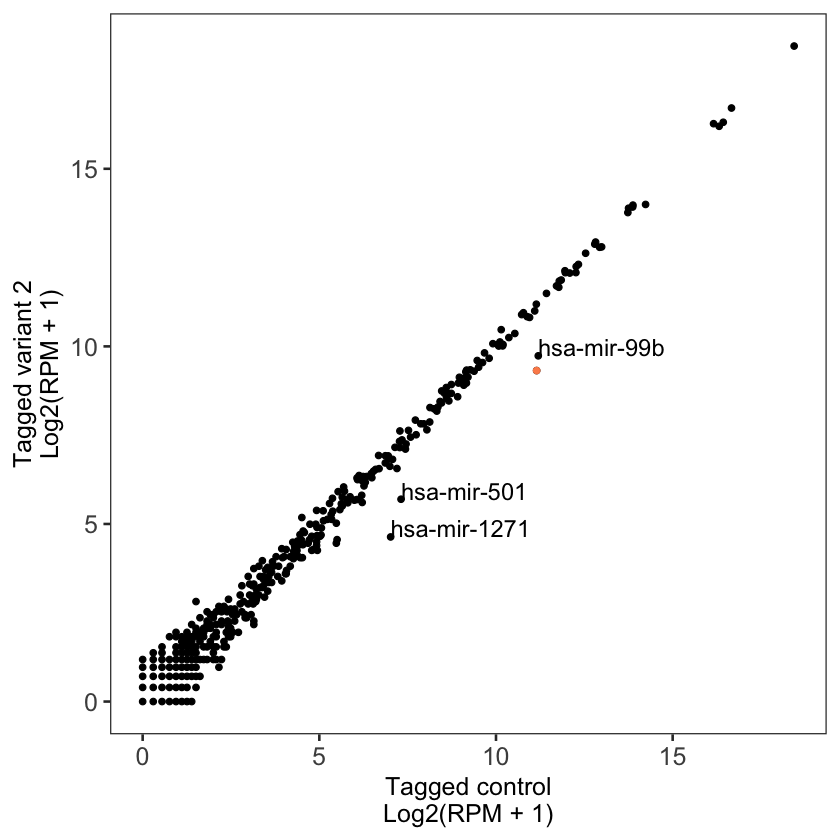

In [32]:
# scatter plot between S02 and S08

library(ggplot2)

df_hairpin_control_vs_test<-df_hairpin[,c("S02","S08")]

## remove the redundant tagged hairpins, such as mir-160001, mir-160002, mir-160003, mir-160004, mir-30001a, mir-30002a, mir-30003a and mir-30004a

ids_to_remove<-c(rownames(df_hairpin_control_vs_test)[grep("1600[1-4].*tagged.*",rownames(df_hairpin_control_vs_test))],
rownames(df_hairpin_control_vs_test)[grep("3000[1-4].*tagged.*",rownames(df_hairpin_control_vs_test))])

df_hairpin_control_vs_test<-df_hairpin_control_vs_test[!rownames(df_hairpin_control_vs_test) %in% ids_to_remove,]

for (i in 1:length(df_hairpin_control_vs_test[1,])){
    df_hairpin_control_vs_test[,i]<-df_hairpin_control_vs_test[,i]/sum(df_hairpin_control_vs_test[,i])*10^6
}


df_hairpin_control_vs_test_log<-log2(df_hairpin_control_vs_test+1)
df_hairpin_control_vs_test_log<-data.frame(df_hairpin_control_vs_test_log)
df_hairpin_control_vs_test_log$group_new<-"S01 vs S08"

## ggplot

#pdf("For_figure_tmp.pdf",width = 4,height = 4)

ids_selected<-rownames(df_hairpin_control_vs_test[order((df_hairpin_control_vs_test[,"S08"]+1)/(df_hairpin_control_vs_test[,"S02"]+1),decreasing = F),][1:5,])
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log[rownames(df_hairpin_control_vs_test_log) %in% ids_selected,]
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log_selected[df_hairpin_control_vs_test_log_selected$S08 > 4,]
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log_selected[-grep("hsa-mir-16000-1",rownames(df_hairpin_control_vs_test_log_selected)),]

### simplified bin plot
library(hexbin)
bin<-hexbin(df_hairpin_control_vs_test_log$S02, df_hairpin_control_vs_test_log$S08, xbins=200,IDs= TRUE)
df_bin<-data.frame(bin@xcm,bin@ycm)
colnames(df_bin)<-c("S02","S08")

ggplot(df_bin,aes(x=S02, y=S08)) + 
geom_point()+
geom_point(data = df_hairpin_control_vs_test_log[grep("16000-",rownames(df_hairpin_control_vs_test_log)),],aes(S02, S08),col="#fc8d59")+
geom_text(data = df_hairpin_control_vs_test_log_selected, aes(label = rownames(df_hairpin_control_vs_test_log_selected)),size=5, vjust = 0, hjust= 0 ,nudge_x = 0,nudge_y = 0)+
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      panel.background = element_blank(),axis.title=element_text(size=15),
      panel.border = element_rect(size=0.7, fill = NA),
      axis.text = element_text(size=15))+
xlab("Tagged control\nLog2(RPM + 1)")+
ylab("Tagged variant 2\nLog2(RPM + 1)")

#dev.off()

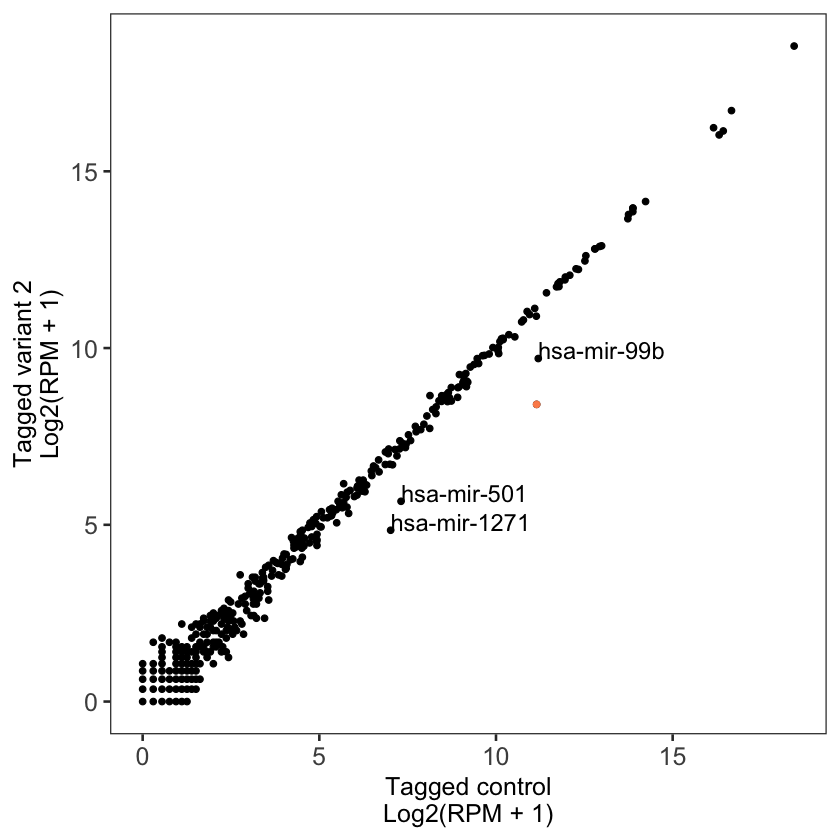

In [33]:
# scatter plot between S02 and S07
library(ggplot2)

df_hairpin_control_vs_test<-df_hairpin[,c("S02","S07")]

## remove the redundant tagged hairpins, such as mir-160001, mir-160002, mir-160003, mir-160004, mir-30001a, mir-30002a, mir-30003a and mir-30004a

ids_to_remove<-c(rownames(df_hairpin_control_vs_test)[grep("1600[1-4].*tagged.*",rownames(df_hairpin_control_vs_test))],
rownames(df_hairpin_control_vs_test)[grep("3000[1-4].*tagged.*",rownames(df_hairpin_control_vs_test))])

df_hairpin_control_vs_test<-df_hairpin_control_vs_test[!rownames(df_hairpin_control_vs_test) %in% ids_to_remove,]

for (i in 1:length(df_hairpin_control_vs_test[1,])){
    df_hairpin_control_vs_test[,i]<-df_hairpin_control_vs_test[,i]/sum(df_hairpin_control_vs_test[,i])*10^6
}


df_hairpin_control_vs_test_log<-log2(df_hairpin_control_vs_test+1)
df_hairpin_control_vs_test_log<-data.frame(df_hairpin_control_vs_test_log)
df_hairpin_control_vs_test_log$group_new<-"S02 vs S07"

## ggplot

#pdf("For_figure_tmp.pdf",width = 4,height = 4)

ids_selected<-rownames(df_hairpin_control_vs_test[order((df_hairpin_control_vs_test[,"S07"]+1)/(df_hairpin_control_vs_test[,"S02"]+1),decreasing = F),][1:5,])
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log[rownames(df_hairpin_control_vs_test_log) %in% ids_selected,]
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log_selected[df_hairpin_control_vs_test_log_selected$S07 > 4,]
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log_selected[-grep("hsa-mir-16000-1",rownames(df_hairpin_control_vs_test_log_selected)),]

### simplified bin plot
library(hexbin)
bin<-hexbin(df_hairpin_control_vs_test_log$S02, df_hairpin_control_vs_test_log$S07, xbins=200,IDs= TRUE)
df_bin<-data.frame(bin@xcm,bin@ycm)
colnames(df_bin)<-c("S02","S07")

ggplot(df_bin,aes(x=S02, y=S07)) + 
geom_point()+
geom_point(data = df_hairpin_control_vs_test_log[grep("16000-",rownames(df_hairpin_control_vs_test_log)),],aes(S02, S07),col="#fc8d59")+
geom_text(data = df_hairpin_control_vs_test_log_selected, aes(label = rownames(df_hairpin_control_vs_test_log_selected)),size=5, vjust = 0, hjust= 0 ,nudge_x = 0,nudge_y = 0)+
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      panel.background = element_blank(),axis.title=element_text(size=15),
      panel.border = element_rect(size=0.7, fill = NA),
      axis.text = element_text(size=15))+
xlab("Tagged control\nLog2(RPM + 1)")+
ylab("Tagged variant 2\nLog2(RPM + 1)")

#dev.off()

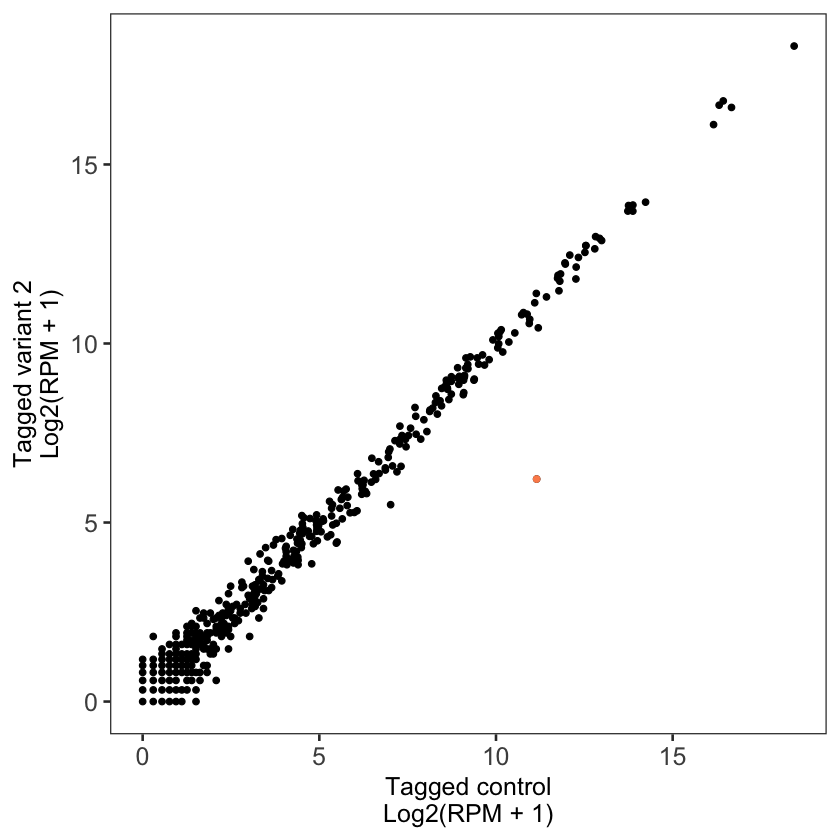

In [34]:
# scatter plot between S02 and S09
library(ggplot2)

df_hairpin_control_vs_test<-df_hairpin[,c("S02","S09")]

## remove the redundant tagged hairpins, such as mir-160001, mir-160002, mir-160003, mir-160004, mir-30001a, mir-30002a, mir-30003a and mir-30004a

ids_to_remove<-c(rownames(df_hairpin_control_vs_test)[grep("1600[1-4].*tagged.*",rownames(df_hairpin_control_vs_test))],
rownames(df_hairpin_control_vs_test)[grep("3000[1-4].*tagged.*",rownames(df_hairpin_control_vs_test))])

df_hairpin_control_vs_test<-df_hairpin_control_vs_test[!rownames(df_hairpin_control_vs_test) %in% ids_to_remove,]

for (i in 1:length(df_hairpin_control_vs_test[1,])){
    df_hairpin_control_vs_test[,i]<-df_hairpin_control_vs_test[,i]/sum(df_hairpin_control_vs_test[,i])*10^6
}


df_hairpin_control_vs_test_log<-log2(df_hairpin_control_vs_test+1)
df_hairpin_control_vs_test_log<-data.frame(df_hairpin_control_vs_test_log)
df_hairpin_control_vs_test_log$group_new<-"S01 vs S09"

## ggplot

#pdf("For_figure_tmp.pdf",width = 4,height = 4)

ids_selected<-rownames(df_hairpin_control_vs_test[order((df_hairpin_control_vs_test[,"S09"]+1)/(df_hairpin_control_vs_test[,"S02"]+1),decreasing = F),][1:5,])
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log[rownames(df_hairpin_control_vs_test_log) %in% ids_selected,]
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log_selected[df_hairpin_control_vs_test_log_selected$S09 > 4,]
df_hairpin_control_vs_test_log_selected<-df_hairpin_control_vs_test_log_selected[-grep("hsa-mir-16000-1",rownames(df_hairpin_control_vs_test_log_selected)),]

### simplified bin plot
library(hexbin)
bin<-hexbin(df_hairpin_control_vs_test_log$S02, df_hairpin_control_vs_test_log$S09, xbins=200,IDs= TRUE)
df_bin<-data.frame(bin@xcm,bin@ycm)
colnames(df_bin)<-c("S02","S09")

ggplot(df_bin,aes(x=S02, y=S09)) + 
geom_point()+
geom_point(data = df_hairpin_control_vs_test_log[grep("16000-",rownames(df_hairpin_control_vs_test_log)),],aes(S02, S09),col="#fc8d59")+
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      panel.background = element_blank(),axis.title=element_text(size=15),
      panel.border = element_rect(size=0.7, fill = NA),
      axis.text = element_text(size=15))+
xlab("Tagged control\nLog2(RPM + 1)")+
ylab("Tagged variant 2\nLog2(RPM + 1)")

#dev.off()

In [35]:
# relative proportion of tagged hairpins

df<-read.table("./MapToCleave_supplemental_data/DataS11:count_table_for_experimental_validation.txt",sep="\t",header=TRUE,check.names = FALSE)

# relative proportion of control sequences
df_16_control<-df[grep("mir-16-1",df$precursor),]
df_30a_control<-df[grep("mir-30a",df$precursor),]
df_125a_control<-df[grep("mir-125a",df$precursor),]

df_16_control_sum<-apply(df_16_control[,5:length(df_16_control[1,])],2,sum)
df_30a_control_sum<-apply(df_30a_control[,5:length(df_30a_control[1,])],2,sum)
df_125a_control_sum<-apply(df_125a_control[,5:length(df_125a_control[1,])],2,sum)

df_16_30a_control_ratio<-df_16_control_sum/df_30a_control_sum
df_30a_125a_control_ratio<-df_30a_control_sum/df_125a_control_sum
df_125a_16_control_ratio<-df_125a_control_sum/df_16_control_sum

df_control_ratio<-cbind(df_16_30a_control_ratio,df_30a_125a_control_ratio,df_125a_16_control_ratio)
df_control_sum<-cbind(df_16_control_sum,df_30a_control_sum,df_125a_control_sum)


# relative proportion of tagged sequences
df_16<-df[grep("mir-16000-1",df$precursor),]
df_30a<-df[grep("mir-30000a",df$precursor),]
df_125a<-df[grep("mir-125000a",df$precursor),]

df_16_sum<-apply(df_16[,5:length(df_16[1,])],2,sum)
df_30a_sum<-apply(df_30a[,5:length(df_30a[1,])],2,sum)
df_125a_sum<-apply(df_125a[,5:length(df_125a[1,])],2,sum)

df_tagged_sum<-cbind(df_16_sum,df_30a_sum,df_125a_sum)

df_tagged_sum_nor<-df_tagged_sum
for (i in 1:length(df_tagged_sum_nor[,1])){
  df_tagged_sum_nor[i,]<-df_tagged_sum_nor[i,]/sum(df_tagged_sum_nor[i,])
}

Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:gridExtra’:

    arrangeGrob, grid.arrange


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplotGrob, ggplot_build, ggplot_gtable,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void





	Exact binomial test

data:  df_tagged_sum[6, 1] and sum(df_tagged_sum[6, ])
number of successes = 10525, number of trials = 1287673, p-value <
2.2e-16
alternative hypothesis: true probability of success is not equal to 0.006345416
95 percent confidence interval:
 0.008018863 0.008330673
sample estimates:
probability of success 
           0.008173659 


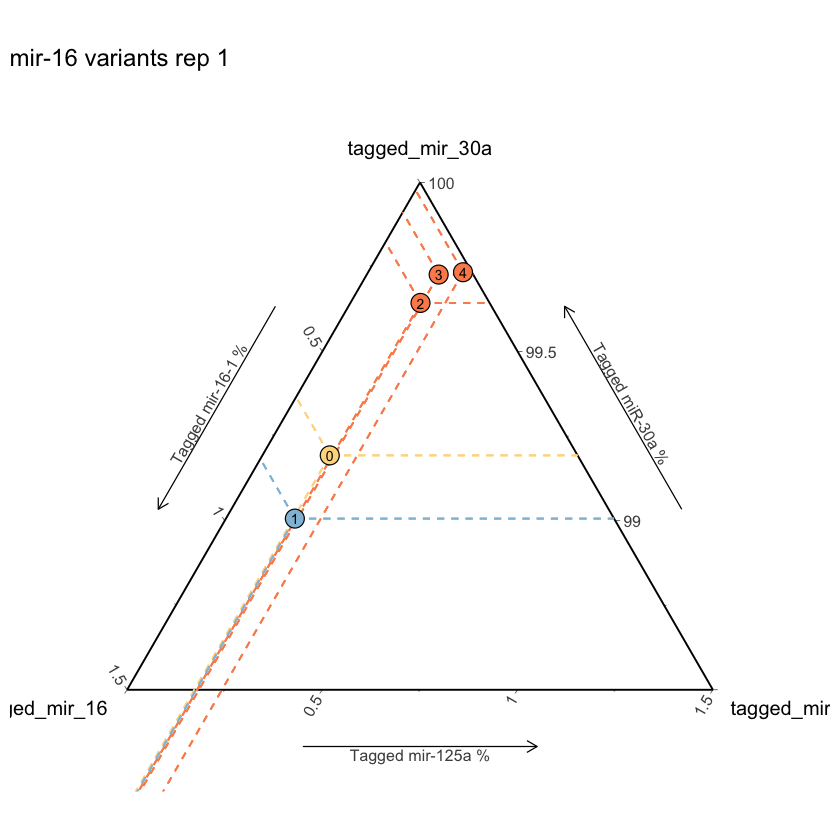

In [36]:
# triangle plot of mir-16 variants

library(ggtern)

#Plot the tested mir-16-1 variants
df_tagged_sum_selected<-df_tagged_sum_nor[c("S02","S06","S08","S07","S09"),]
df_tagged_sum_selected<-data.frame(df_tagged_sum_selected)
df_tagged_sum_selected$label<-c("0","1","2","3","4")
df_tagged_sum_selected$color<-c("control","increased","decreased","decreased","decreased")
df_tagged_sum_selected$fill<-c("control","increased","decreased","decreased","decreased")

df.lims = data.frame(df_16_sum = c(0.015,0,0), 
                     df_30a_sum = c(0.985,1,0.985), 
                     df_125a_sum = c(0,0,0.015))

#pdf("triangle_plot.pdf",width = 3.5,height = 3.5)
colnames(df_tagged_sum_selected)<-c("tagged_mir_16","tagged_mir_30a","tagged_mir_125a","label","color","fill")
rownames(df_tagged_sum_selected)<-c("Control:S02","UCG_GGC:S06","CCG_GCU:S08","GUG_UGU-S07","GUA_UUG:S09")
ggtern(df_tagged_sum_selected,aes(tagged_mir_16,tagged_mir_30a,tagged_mir_125a,color=color,fill=fill)) + 
  theme_classic()+
  geom_crosshair_tern(lty=2)+
  geom_point(shape=21,size=5,col="black")+
  theme_showarrows()+
  labs(title  = "mir-16 variants rep 1",Tarrow = "Tagged miR-30a %",Larrow = "Tagged mir-16-1 %",Rarrow = "Tagged mir-125a %") +
  theme(tern.axis.arrow=element_line(size=1,color="black")) +
  tern_limits(T=max(df.lims$df_30a_sum), L=max(df.lims$df_16_sum), R=max(df.lims$df_125a_sum))+
  theme_nomask() +
  scale_fill_manual(values=c("#fed98e","#fc8d59","#91bfdb"))+
  scale_color_manual(values=c("#fed98e","#fc8d59","#91bfdb"))+
  geom_text(aes(label=df_tagged_sum_selected[,4]),alpha=1,col="black",size=3) +
  guides(fill='none',color='none')

#dev.off()

binom.test(x=df_tagged_sum[6,1], n= sum(df_tagged_sum[6,]),p = df_tagged_sum_selected[1,1])

### Code related to Figure 7B

Feature importance estimation using MapToCleave data

In [37]:
# load feature table
df_m<-read.table("./MapToCleave_supplemental_data/DataS8:MapToCleave_feature_importance_estimation.txt",sep="\t",header=TRUE, row.names=1,check.names = F)

df_m<-df_m[,c(which(colnames(df_m) %in% c('log2_fold_change','UG_atBasalJunction','UGUorGUG_atApicalJunction','CNNC_at3pFlanking','GHG_defined_by_bulge')),
            grep("free_energy_",colnames(df_m)),
             which(colnames(df_m) %in% paste('Shannon_entropy_at',seq(0,10),'_from_5p_start',sep="")),
             which(colnames(df_m) %in% paste('Shannon_entropy_at',seq(11,21),'_from_3p_start',sep="")))]




adjr2<-vector()
colnames(df_m)<-gsub("free_energy_4mer_at","stemscan",colnames(df_m))

ref<-data.frame(colnames(df_m),rep(0,times=length(colnames(df_m))))
ref[,1]<-as.character(ref[,1])
colnames(ref)<-c("ref","value")

In [38]:
# linear regression models
CNNC<-"CNNC_at3pFlanking"
UG<-"UG_atBasalJunction"
GHG_new<-c("stemscan-8","stemscan-7")
UGUG<-"UGUorGUG_atApicalJunction"
lower_basal_stem<-c("stemscan-14","stemscan-13","stemscan-12","stemscan-11","stemscan-10")
BD1<-c("stemscan1","stemscan2","stemscan3")
BD2<-c("stemscan14","stemscan15","stemscan16")
GHG_by_bulge<-"GHG_defined_by_bulge"
shannon_entropy<-colnames(df_m)[grep("entropy",colnames(df_m))]
other_locals<-colnames(df_m)[grep("stemscan",colnames(df_m))]
other_locals<-other_locals[!other_locals %in% GHG_new]
other_locals<-other_locals[!other_locals %in% lower_basal_stem]
other_locals<-other_locals[!other_locals %in% BD1]
other_locals<-other_locals[!other_locals %in% BD2]
other_locals<-other_locals[!other_locals %in% GHG_by_bulge]

# when using 4-mers
subset_features<-list()
subset_features[[1]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge,other_locals,UG,UGUG,CNNC,shannon_entropy)
subset_features[[2]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge)
subset_features[[3]]<-c(UG,UGUG,CNNC,GHG_by_bulge,lower_basal_stem,BD1,BD2)
subset_features[[4]]<-c(UG,UGUG,CNNC)
subset_features[[5]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge,UG,UGUG,CNNC,shannon_entropy)
subset_features[[6]]<-lower_basal_stem
subset_features[[7]]<-BD1
subset_features[[8]]<-BD2
subset_features[[9]]<-GHG_by_bulge
subset_features[[10]]<-UG
subset_features[[11]]<-UGUG
subset_features[[12]]<-CNNC
subset_features[[13]]<-other_locals
subset_features[[14]]<-shannon_entropy
subset_features[[15]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge,other_locals,UG,UGUG,CNNC)
subset_features[[16]]<-c(BD1,BD2,GHG_by_bulge,other_locals,UG,UGUG,CNNC,shannon_entropy)
subset_features[[17]]<-c(lower_basal_stem,BD1,BD2,other_locals,UG,UGUG,CNNC,shannon_entropy)
subset_features[[18]]<-c(BD1,BD2,GHG_by_bulge)
subset_features[[19]]<-c(lower_basal_stem,BD1,BD2)
subset_features[[20]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge,other_locals,UG,UGUG,shannon_entropy)


for (i in 1:length(subset_features)){
    #print(i)
    model <- paste("log2_fold_change ~ ",paste("`",subset_features[[i]],"`",collapse = "+", sep=""),sep="")
    #print(model)
    fit <- lm(model, df_m)
    summary.fit<-summary(fit)
    adjr2<-c(adjr2,summary.fit$adj.r.squared)
    #print(adjr2)

    ref_tmp<-ref
    ref_tmp[ref_tmp[,1] %in% subset_features[[i]],][,2]<-1
    colnames(ref_tmp)[2]<-i
    
    if (i == 1){
        df_lm_out<-ref_tmp
    } else {
        df_lm_out<-merge(df_lm_out,ref_tmp,by.x="ref",by.y="ref")
    }
    
}

rownames(df_lm_out)<-df_lm_out[,1]
df_lm_out[,1]<-NULL
df_lm_out<-data.frame(t(df_lm_out),check.names = F)
df_lm_out<-df_lm_out[,ref[,1]]
df_lm_out$adjr2<-adjr2*100
df_lm_out<-df_lm_out[order(df_lm_out$adjr2,decreasing = T),]
df_lm_out$log2_fold_change<-NULL

In [39]:
# prepare the table for ploting
df_lm_out_collapsed<-df_lm_out
df_lm_out_collapsed<-data.frame(t(df_lm_out_collapsed),check.names = F)


features<-c("UG_atBasalJunction","UGUorGUG_atApicalJunction","CNNC_at3pFlanking","GHG_defined_by_bulge",
                               "stemscan-16","stemscan-15",
                                "lower_basal_stem","lower_basal_stem","lower_basal_stem","lower_basal_stem","lower_basal_stem",
                               "stemscan-9",
                               "GHG/bulge+","GHG/bulge+",
                               "stemscan-6","stemscan-5","stemscan-4","stemscan-3","stemscan-2","stemscan-1","stemscan0",
                               "Roden:bulge-1","Roden:bulge-1","Roden:bulge-1",
                               "stemscan4","stemscan5","stemscan6","stemscan7","stemscan8","stemscan9","stemscan10","stemscan11","stemscan12","stemscan13",
                               "Roden:bulge-2","Roden:bulge-2","Roden:bulge-2",
                               "stemscan17","stemscan18","stemscan19","stemscan20",
                                rep("entropy",times=length(grep("entropy",colnames(df_lm_out)))),
                                "adjr2"
                               )

features_collapsed<-gsub("stemscan.*","others",features)


feature_collapsed_ordered<-c("UG_atBasalJunction","UGUorGUG_atApicalJunction","CNNC_at3pFlanking",
                                "lower_basal_stem", "GHG_defined_by_bulge",                                
                               "Roden:bulge-1",
                               "Roden:bulge-2",
                                "others",
                                "entropy",
                                "adjr2"
                               )


df_lm_out_collapsed$feature<-features_collapsed


df_lm_out_collapsed<-df_lm_out_collapsed[order(df_lm_out_collapsed$feature),]
df_lm_out_collapsed<-unique(df_lm_out_collapsed)

rownames(df_lm_out_collapsed)<-df_lm_out_collapsed$feature
df_lm_out_collapsed$feature<-NULL

df_lm_out_collapsed<-data.frame(t(df_lm_out_collapsed),check.names = F)
df_lm_out_collapsed<-df_lm_out_collapsed[,feature_collapsed_ordered]

df_lm_out_collapsed_v2<-df_lm_out_collapsed

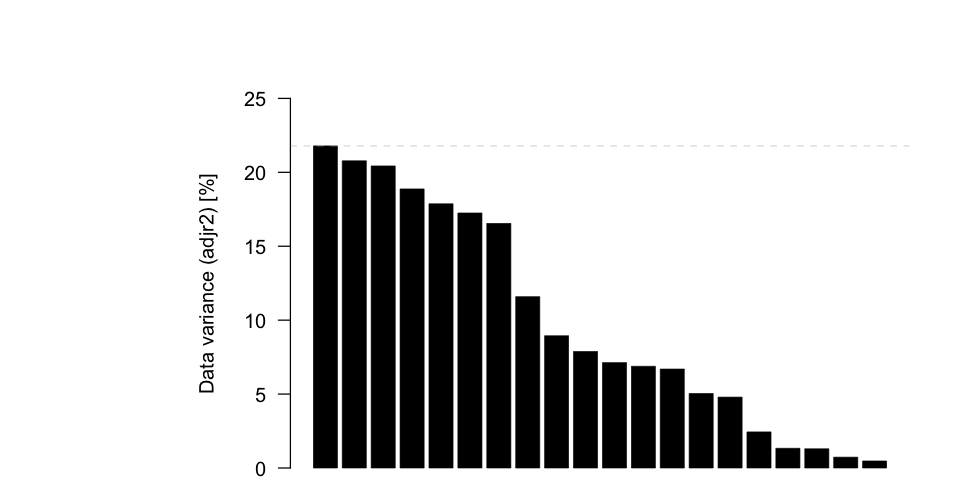

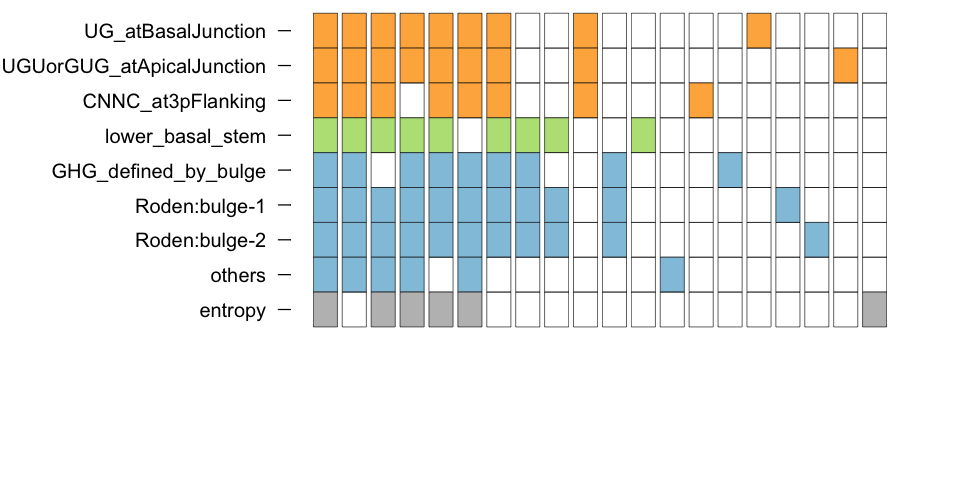

In [40]:
# plotting
options(repr.plot.width=8, repr.plot.height=4)

df_leaps_all<-df_lm_out_collapsed_v2


df_heatmap<-t(df_leaps_all[,1:(length(df_leaps_all[1,])-1)])

df_heatmap[1:3,][which(df_heatmap[1:3,]==1)]<-"#feb24c"
df_heatmap[4,][which(df_heatmap[4,]==1)]<-"#b8e186"
df_heatmap[5,][which(df_heatmap[5,]==1)]<-"#92c5de"
df_heatmap[6:8,][which(df_heatmap[6:8,]==1)]<-"#92c5de"
df_heatmap[9,][which(df_heatmap[9,]==1)]<-"grey"

#pdf("For_figure_tmp.pdf",width = 7,height=5.5)

lty.o <- par("lty")
par(lty = 1,lwd=0.5)

#par(mfcol = c(2, 1))
par(mar=c(0.5,12.1,4.1,2.1))

coor<-barplot(df_leaps_all$adjr2,col="black",las=2,
              ylab="Data variance (adjr2) [%]",ylim = c(0,25),
              yaxt = 'n')
axis(2, at=seq(0,25,5), labels=seq(0,25,5), tick=TRUE, las=2, line=0, cex.axis=1)
abline(h=df_leaps_all[1,"adjr2"],col="grey",lty=2)

par(mar=c(5.1,12.1,0,2.1))
plot(1, type="n", xlab="", ylab="", xlim=c(min(coor)-0.5, max(coor)+0.5), ylim=c((length(df_heatmap[,1])+0.5)*(-1), 0), axes=FALSE)

for (j in 1:length(df_heatmap[,1])){
    number<-coor-0.5
    for (i in 1:length(number)){  
        polygon(x = c(number[i], number[i]+1, number[i]+1, number[i]),                           # X-Coordinates of polygon
            y = c(-1*j+1,-1*j+1 , -1*j, -1*j),                             # Y-Coordinates of polygon
            col = df_heatmap[j,][i])   
    }
    axis(2,at=-1*j+0.5,labels = rownames(df_heatmap)[j],las=2)
}

#dev.off()

In [41]:
plot_order<-rownames(df_leaps_all)

Feature importance estimation using MirGeneDB in vivo expression data

In [42]:
df_m_mirgenedb_entropy<-read.table("./MapToCleave_supplemental_data/DataS14:in_vivo_expression_feature_importance_estimation.txt",sep="\t",header=TRUE, row.names=1,check.names = F)


df_m_mirgenedb_entropy<-df_m_mirgenedb_entropy[,c(which(colnames(df_m_mirgenedb_entropy) %in% c('mean_RPM','UG_atBasalJunction','UGUorGUG_atApicalJunction','CNNC_at3pFlanking','GHG_defined_by_bulge')),
            grep("free_energy_",colnames(df_m_mirgenedb_entropy)),
             which(colnames(df_m_mirgenedb_entropy) %in% paste('Shannon_entropy_at',seq(0,10),'_from_5p_start',sep="")),
             which(colnames(df_m_mirgenedb_entropy) %in% paste('Shannon_entropy_at',seq(11,21),'_from_3p_start',sep="")))]



colnames(df_m_mirgenedb_entropy)<-gsub("free_energy_4mer_at","stemscan",colnames(df_m_mirgenedb_entropy))


In [43]:
length(df_m_mirgenedb_entropy[,1])

[1] 501

In [44]:
ref<-data.frame(colnames(df_m_mirgenedb_entropy),rep(0,times=length(colnames(df_m_mirgenedb_entropy))))
colnames(ref)<-c("ref","value")
adjr2<-vector()

CNNC<-"CNNC_at3pFlanking"
UG<-"UG_atBasalJunction"
GHG_new<-c("stemscan-8","stemscan-7")
UGUG<-"UGUorGUG_atApicalJunction"
lower_basal_stem<-c("stemscan-14","stemscan-13","stemscan-12","stemscan-11","stemscan-10")
BD1<-c("stemscan1","stemscan2","stemscan3")
BD2<-c("stemscan14","stemscan15","stemscan16")
GHG_by_bulge<-"GHG_defined_by_bulge"
shannon_entropy<-colnames(df_m_mirgenedb_entropy)[grep("entropy",colnames(df_m_mirgenedb_entropy))]
other_locals<-colnames(df_m_mirgenedb_entropy)[grep("stemscan",colnames(df_m_mirgenedb_entropy))]
other_locals<-other_locals[!other_locals %in% GHG_new]
other_locals<-other_locals[!other_locals %in% lower_basal_stem]
other_locals<-other_locals[!other_locals %in% BD1]
other_locals<-other_locals[!other_locals %in% BD2]
other_locals<-other_locals[!other_locals %in% GHG_by_bulge]

# when using 4-mers
subset_features<-list()
subset_features[[1]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge,other_locals,UG,UGUG,CNNC,shannon_entropy)
subset_features[[2]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge)
subset_features[[3]]<-c(UG,UGUG,CNNC,GHG_by_bulge,lower_basal_stem,BD1,BD2)
subset_features[[4]]<-c(UG,UGUG,CNNC)
subset_features[[5]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge,UG,UGUG,CNNC,shannon_entropy)
subset_features[[6]]<-lower_basal_stem
subset_features[[7]]<-BD1
subset_features[[8]]<-BD2
subset_features[[9]]<-GHG_by_bulge
subset_features[[10]]<-UG
subset_features[[11]]<-UGUG
subset_features[[12]]<-CNNC
subset_features[[13]]<-other_locals
subset_features[[14]]<-shannon_entropy
subset_features[[15]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge,other_locals,UG,UGUG,CNNC)
subset_features[[16]]<-c(BD1,BD2,GHG_by_bulge,other_locals,UG,UGUG,CNNC,shannon_entropy)
subset_features[[17]]<-c(lower_basal_stem,BD1,BD2,other_locals,UG,UGUG,CNNC,shannon_entropy)
subset_features[[18]]<-c(BD1,BD2,GHG_by_bulge)
subset_features[[19]]<-c(lower_basal_stem,BD1,BD2)
subset_features[[20]]<-c(lower_basal_stem,BD1,BD2,GHG_by_bulge,other_locals,UG,UGUG,shannon_entropy)



for (i in 1:length(subset_features)){
    model <- paste("log2(mean_RPM+1) ~ ",paste("`",subset_features[[i]],"`",collapse = "+", sep=""),sep="")
    fit <- lm(model, df_m_mirgenedb_entropy)
    summary.fit<-summary(fit)
    adjr2<-c(adjr2,summary.fit$adj.r.squared)

    ref_tmp<-ref
    ref_tmp[ref_tmp[,1] %in% subset_features[[i]],][,2]<-1
    colnames(ref_tmp)[2]<-i
    
    if (i == 1){
        df_lm_out<-ref_tmp
    } else {
        df_lm_out<-merge(df_lm_out,ref_tmp,by.x="ref",by.y="ref")
    }
    
}


rownames(df_lm_out)<-df_lm_out[,1]
df_lm_out[,1]<-NULL
df_lm_out<-data.frame(t(df_lm_out),check.names = F)
df_lm_out<-df_lm_out[,ref[,1]]
df_lm_out$adjr2<-adjr2*100
df_lm_out<-df_lm_out[order(df_lm_out$adjr2,decreasing = T),]
df_lm_out$mean_RPM<-NULL

In [45]:
df_lm_out_collapsed<-df_lm_out
df_lm_out_collapsed<-data.frame(t(df_lm_out_collapsed),check.names = F)

features<-c("UG_atBasalJunction","UGUorGUG_atApicalJunction","CNNC_at3pFlanking","GHG_defined_by_bulge",
                               "stemscan-16","stemscan-15",
                                "lower_basal_stem","lower_basal_stem","lower_basal_stem","lower_basal_stem","lower_basal_stem",
                               "stemscan-9",
                               "GHG/bulge+","GHG/bulge+",
                               "stemscan-6","stemscan-5","stemscan-4","stemscan-3","stemscan-2","stemscan-1","stemscan0",
                               "Roden:bulge-1","Roden:bulge-1","Roden:bulge-1",
                               "stemscan4","stemscan5","stemscan6","stemscan7","stemscan8","stemscan9","stemscan10","stemscan11","stemscan12","stemscan13",
                               "Roden:bulge-2","Roden:bulge-2","Roden:bulge-2",
                               "stemscan17","stemscan18","stemscan19","stemscan20",
                                rep("entropy",times=length(grep("entropy",colnames(df_lm_out)))),
                                "adjr2"
                               )

feature_ordered<-c("UG_atBasalJunction","UGUorGUG_atApicalJunction","GHG_defined_by_bulge","CNNC_at3pFlanking",
                               "stemscan-16","stemscan-15",
                                "lower_basal_stem",                                 
                                "stemscan-9",
                               "stemscan-6","stemscan-5","stemscan-4","stemscan-3","stemscan-2","stemscan-1","stemscan0",
                               "Roden:bulge-1",
                               "stemscan4","stemscan5","stemscan6","stemscan7","stemscan8","stemscan9","stemscan10","stemscan11","stemscan12","stemscan13",
                               "Roden:bulge-2",
                               "stemscan17","stemscan18","stemscan19","stemscan20",
                               "entropy",
                                "adjr2"
                               )

df_lm_out_collapsed$feature<-features
df_lm_out_collapsed<-unique(df_lm_out_collapsed)

rownames(df_lm_out_collapsed)<-df_lm_out_collapsed$feature
df_lm_out_collapsed$feature<-NULL

df_lm_out_collapsed<-data.frame(t(df_lm_out_collapsed),check.names = F)
df_lm_out_collapsed<-df_leaps_all<-df_lm_out_collapsed[,feature_ordered]
df_lm_out_collapsed_v1<-df_lm_out_collapsed

In [46]:
df_lm_out_collapsed<-df_lm_out
df_lm_out_collapsed<-data.frame(t(df_lm_out_collapsed),check.names = F)
features_collapsed<-gsub("stemscan.*","others",features)
feature_collapsed_ordered<-c("UG_atBasalJunction","UGUorGUG_atApicalJunction","CNNC_at3pFlanking",
                                "lower_basal_stem", "GHG_defined_by_bulge",                                
                               "Roden:bulge-1",
                               "Roden:bulge-2",
                                "others",
                                "entropy",
                                "adjr2"
                               )

df_lm_out_collapsed$feature<-features_collapsed

df_lm_out_collapsed<-df_lm_out_collapsed[order(df_lm_out_collapsed$feature),]
df_lm_out_collapsed<-unique(df_lm_out_collapsed)

rownames(df_lm_out_collapsed)<-df_lm_out_collapsed$feature
df_lm_out_collapsed$feature<-NULL

df_lm_out_collapsed<-data.frame(t(df_lm_out_collapsed),check.names = F)
df_lm_out_collapsed<-df_lm_out_collapsed[,feature_collapsed_ordered]

df_lm_out_collapsed_v2<-df_lm_out_collapsed


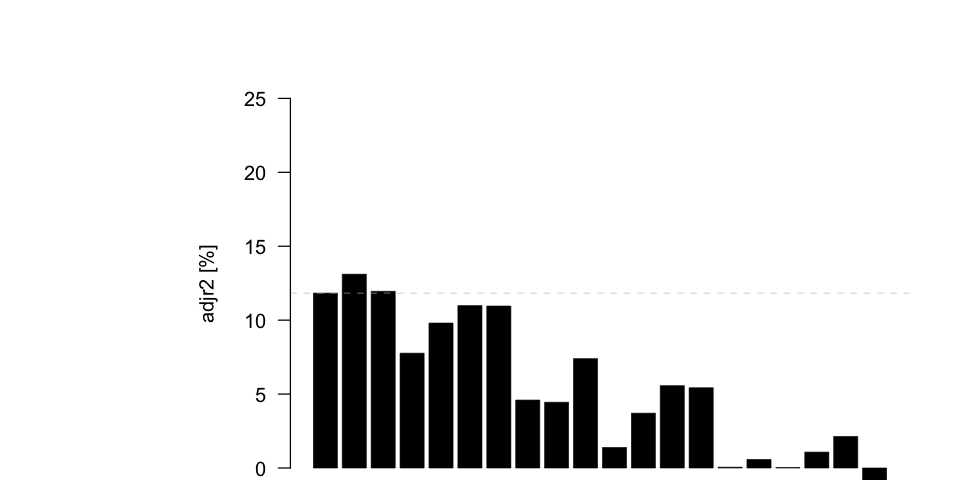

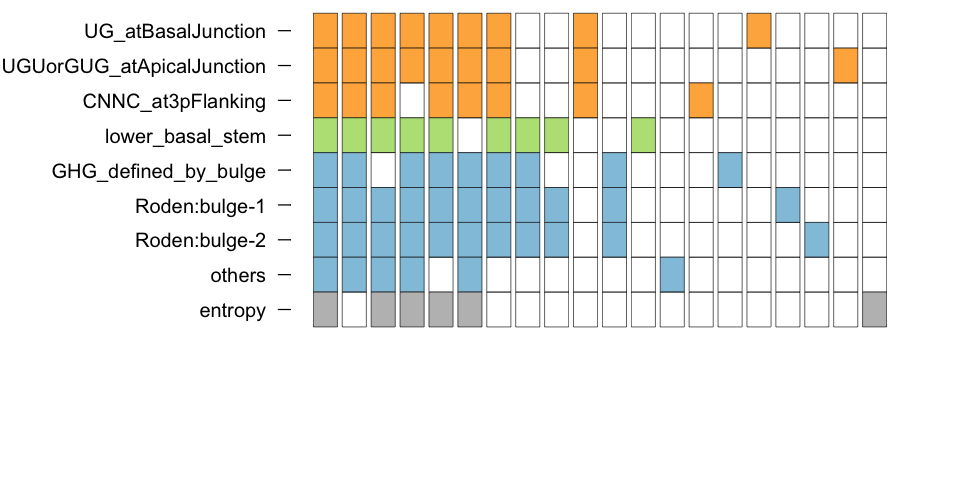

In [47]:
# plotting
options(repr.plot.width=8, repr.plot.height=4)

df_leaps_all<-df_lm_out_collapsed_v2

df_leaps_all<-df_leaps_all[plot_order,]


df_heatmap<-t(df_leaps_all[,1:(length(df_leaps_all[1,])-1)])

df_heatmap[1:3,][which(df_heatmap[1:3,]==1)]<-"#feb24c"
df_heatmap[4,][which(df_heatmap[4,]==1)]<-"#b8e186"
df_heatmap[5,][which(df_heatmap[5,]==1)]<-"#92c5de"
df_heatmap[6:8,][which(df_heatmap[6:8,]==1)]<-"#92c5de"
df_heatmap[9,][which(df_heatmap[9,]==1)]<-"grey"


#pdf("For_figure_tmp2.pdf",width = 7,height=5.5)

lty.o <- par("lty")
par(lty = 1,lwd=0.5)

#par(mfcol = c(2, 1))
par(mar=c(0.5,12.1,4.1,2.1))

coor<-barplot(df_leaps_all$adjr2,col="black",las=2,
              ylab="adjr2 [%]",ylim = c(0,25),
              yaxt = 'n')
axis(2, at=seq(0,25,5), labels=seq(0,25,5), tick=TRUE, las=2, line=0, cex.axis=1)
abline(h=df_leaps_all[1,"adjr2"],col="grey",lty=2)

par(mar=c(5.1,12.1,0,2.1))
plot(1, type="n", xlab="", ylab="", xlim=c(min(coor)-0.5, max(coor)+0.5), ylim=c((length(df_heatmap[,1])+0.5)*(-1), 0), axes=FALSE)

for (j in 1:length(df_heatmap[,1])){
    number<-coor-0.5
    for (i in 1:length(number)){  
        polygon(x = c(number[i], number[i]+1, number[i]+1, number[i]),                           # X-Coordinates of polygon
            y = c(-1*j+1,-1*j+1 , -1*j, -1*j),                             # Y-Coordinates of polygon
            col = df_heatmap[j,][i])   
    }
    axis(2,at=-1*j+0.5,labels = rownames(df_heatmap)[j],las=2)
}

#dev.off()